In [6]:
import os
import sys

data_path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if data_path not in sys.path:
    sys.path.append(data_path)

print("Final sys.path:", sys.path)


Final sys.path: ['/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/benchmarks/stage_2_best_4_fms', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '__editable__.lag_llama-0.1.0.finder.__path_hook__', '/opt/anaconda3/lib/python3.12/site-packages/aeosa', '/opt/anaconda3/lib/python3.12/site-packages/setuptools/_vendor', '/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/tmp7_0mp5gd', '/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial']


In [7]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-urfkxcdn
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-urfkxcdn
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 94e20ea7e510ac4d665492b8bed8836a5143f16e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


## One-step Sliding Window

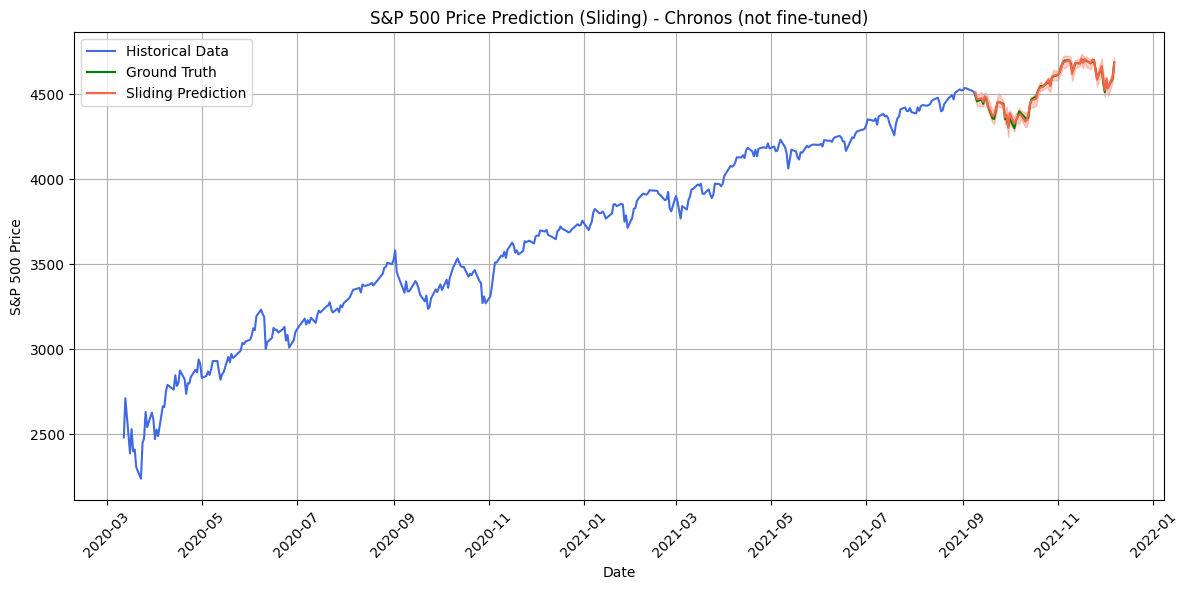


Chronos Sliding Forecast Metrics:
MAE: 31.9433
MSE: 1709.6313
RMSE: 41.3477
Z-NormalizedMAE: 0.2507
Z-NormalizedMSE: 0.1053
Z-NormalizedRMSE: 0.3245
MAPE: 0.7086
SMAPE: 0.7075
MASE: 0.9922
DirectionalAccuracy: 52.8302


In [18]:
import pandas as pd
import numpy as np
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from utils.metrics import calculate_metrics

# Constants
CONTEXT_WINDOW = 378
FORECAST_STEPS = 63
PREDICTION_LENGTH = 1

# Initialize Chronos
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="mps",
    torch_dtype=torch.bfloat16,
)

class TimeSeriesPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def fit_scaler(self, data):
        """Fit scaler on training data"""
        self.scaler.fit(data.reshape(-1, 1))
        
    def generate_single_forecast(self, context_data):
        """Generate single-step forecast with Chronos"""
        # Scale the context data
        context_scaled = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        
        # Convert to tensor and ensure proper shape
        context = torch.tensor(context_scaled, dtype=torch.float32)
        
        # Generate forecast
        with torch.no_grad():
            forecast = pipeline.predict(context, PREDICTION_LENGTH)
        
        # Extract samples and convert back to original scale
        forecast_np = forecast[0].cpu().numpy()  # [num_samples, prediction_length]
        forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1)).reshape(forecast_np.shape)
        
        # Calculate quantiles
        low = np.quantile(forecast_original, 0.1, axis=0).item()
        median = np.quantile(forecast_original, 0.5, axis=0).item()
        high = np.quantile(forecast_original, 0.9, axis=0).item()
        
        return low, median, high

    def generate_recursive_forecasts(self, data, start_idx):
        """Recursive forecasting implementation"""
        all_forecasts = {
            'median': [], 'low': [], 'high': [], 'dates': []
        }
        
        # Initialize context window
        context_data = data['Close'].iloc[start_idx - CONTEXT_WINDOW:start_idx].to_numpy()
        
        # Fit scaler on context data
        self.fit_scaler(context_data)
        
        # Calculate forecast dates
        forecast_dates = pd.date_range(
            start=data['Date'].iloc[start_idx],
            periods=FORECAST_STEPS,
            freq='D'
        )
        
        for i in range(FORECAST_STEPS):
            # Generate forecast
            low, median, high = self.generate_single_forecast(context_data)
            
            # Store results
            all_forecasts['median'].append(median)
            all_forecasts['low'].append(low)
            all_forecasts['high'].append(high)
            all_forecasts['dates'].append(forecast_dates[i])
            
            # Update context window
            context_data = np.append(context_data[1:], median)
            
        return all_forecasts

    def generate_sliding_window_forecasts(self, data, start_idx):
        """Sliding window implementation"""
        all_forecasts = {
            'median': [], 'low': [], 'high': [], 'dates': []
        }
        
        # Fit scaler on initial context window
        initial_context = data['Close'].iloc[start_idx - CONTEXT_WINDOW:start_idx].to_numpy()
        self.fit_scaler(initial_context)
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = current_idx - CONTEXT_WINDOW
            
            # Get context window
            context_data = data['Close'].iloc[context_start:current_idx].to_numpy()
            
            # Generate forecast
            low, median, high = self.generate_single_forecast(context_data)
            
            # Store results
            all_forecasts['median'].append(median)
            all_forecasts['low'].append(low)
            all_forecasts['high'].append(high)
            all_forecasts['dates'].append(data['Date'].iloc[current_idx - 1])
        
        return all_forecasts

def plot_forecasts(data, start_idx, forecasts, method="recursive"):
    """Visualization for forecasts"""
    plt.figure(figsize=(12, 6))
    
    # Historical context
    context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx]
    plt.plot(context_data['Date'], context_data['Close'], 
             color='royalblue', label='Historical Data')
    
    # Actual prices
    actual_data = data.iloc[start_idx - 1:start_idx + FORECAST_STEPS - 1]
    plt.plot(actual_data['Date'], actual_data['Close'], 
             color='green', label='Ground Truth')
    
    # Predictions
    plt.plot(forecasts['dates'], forecasts['median'], 
             color='tomato', label=f'{method.capitalize()} Prediction')
    plt.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'], 
                     color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title(f'S&P 500 Price Prediction ({method.capitalize()}) - Chronos (not fine-tuned)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_experiment(data, target_date, method="recursive"):
    """Run forecasting experiment"""
    predictor = TimeSeriesPredictor()
    target_date = pd.Timestamp(target_date)
    start_idx = data[data['Date'] <= target_date].index[-1]
    
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")
    
    if method.lower() == "recursive":
        forecasts = predictor.generate_recursive_forecasts(data, start_idx)
    else:
        forecasts = predictor.generate_sliding_window_forecasts(data, start_idx)
    
    plot_forecasts(data, start_idx, forecasts, method)
    
    # Calculate metrics
    actual_values = data['Close'].iloc[start_idx:start_idx + FORECAST_STEPS].values
    insample_values = data['Close'].iloc[start_idx - CONTEXT_WINDOW:start_idx].values
    metrics = calculate_metrics(actual_values, np.array(forecasts['median']), insample_values)
    
    print(f"\nChronos {method.capitalize()} Forecast Metrics:")
    for metric_name, value in metrics.items():
        if value is not None:
            print(f"{metric_name}: {value:.4f}")
        else:
            print(f"{metric_name}: None")

from data.snp500 import snp500_daily

sp500_d = snp500_daily

target_date = '2021-09-09'

run_experiment(sp500_d, target_date, method="sliding")

## Autoregressive

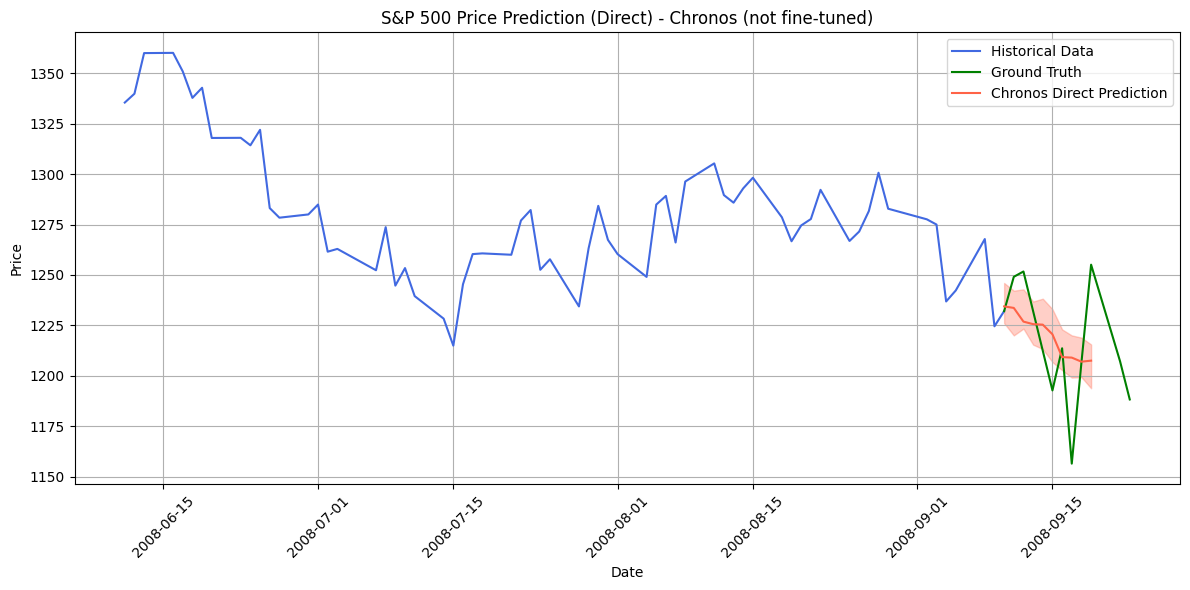


Chronos Direct Forecast Metrics:
MAE: 21.9584
MSE: 869.9548
RMSE: 29.4950
Z-NormalizedMAE: 0.7244
Z-NormalizedMSE: 0.9468
Z-NormalizedRMSE: 0.9730
MAPE: 1.8211
SMAPE: 1.8102
MASE: nan
DirectionalAccuracy: nan


In [18]:
import pandas as pd
import numpy as np
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from utils.metrics import calculate_metrics
from data.snp500 import snp500_daily

# Constants
CONTEXT_WINDOW = 560
FORECAST_STEPS = 10
PREDICTION_LENGTH = 1

sp500_d = snp500_daily
# Initialize Chronos once (large T5 variant)
pipeline = ChronosPipeline.from_pretrained(
    # "amazon/chronos-t5-tiny",
    "./ft_chronos_tiny_rk2_3000/checkpoint-final",
    device_map="mps",
    torch_dtype=torch.bfloat16,
)

class TimeSeriesPredictor:
    def __init__(self):
        self.scaler = StandardScaler()

    def fit_scaler(self, data):
        """Fit scaler on the given 1D numpy array."""
        self.scaler.fit(data.reshape(-1, 1))
        
    def generate_single_forecast(self, context_data):
        """(Existing) Single-step forecast with Chronos, for reference."""
        # Scale the context
        context_scaled = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context = torch.tensor(context_scaled, dtype=torch.float32)
        
        with torch.no_grad():
            # Generate single-step forecast
            # Note: Using 'PREDICTION_LENGTH=1' in pipeline.predict
            forecast = pipeline.predict(context, PREDICTION_LENGTH)
        
        forecast_np = forecast[0].cpu().numpy()  # shape: [num_samples, 1]
        forecast_unscaled = self.scaler.inverse_transform(
            forecast_np.reshape(-1, 1)
        ).reshape(forecast_np.shape)
        
        low = np.quantile(forecast_unscaled, 0.1, axis=0).item()
        median = np.quantile(forecast_unscaled, 0.5, axis=0).item()
        high = np.quantile(forecast_unscaled, 0.9, axis=0).item()
        return low, median, high

    def generate_direct_multi_step_forecast(self, context_data, horizon=FORECAST_STEPS):
        """
        Direct multi-step forecast in ONE forward pass.
        - context_data: 1D array of the last CONTEXT_WINDOW points.
        - horizon: number of future steps (128) to predict at once.
        Returns arrays (low_arr, median_arr, high_arr) each of length 'horizon'.
        """
        # Scale the context
        context_scaled = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context_tensor = torch.tensor(context_scaled, dtype=torch.float32)
        
        with torch.no_grad():
            # Predict 'horizon' steps in one shot
            forecast = pipeline.predict(context_tensor, horizon)
            # forecast[0] shape: (num_samples, horizon)
        
        forecast_np = forecast[0].cpu().numpy()  # shape: [num_samples, horizon]
        
        # Invert scaling
        # Flatten to shape (num_samples * horizon, 1), then reshape back
        forecast_unscaled = self.scaler.inverse_transform(
            forecast_np.reshape(-1, 1)
        ).reshape(forecast_np.shape)
        
        # Compute quantiles across the samples dimension
        low_arr = np.quantile(forecast_unscaled, 0.1, axis=0)
        median_arr = np.quantile(forecast_unscaled, 0.5, axis=0)
        high_arr = np.quantile(forecast_unscaled, 0.9, axis=0)
        
        return low_arr, median_arr, high_arr

    def generate_direct_multi_step_forecasts(self, data, start_idx):
        """
        Generate multi-step forecasts in one pass (no for-loop).
        - data: DataFrame with columns ['Date', 'Close'].
        - start_idx: integer index from which to predict.
        Returns dict with arrays for low, median, high, and corresponding dates.
        """
        all_forecasts = {
            'median': [],
            'low': [],
            'high': [],
            'dates': []
        }
        
        # 1) Extract context window (last CONTEXT_WINDOW points)
        context_data = data['Close'].iloc[start_idx - CONTEXT_WINDOW : start_idx].to_numpy()
        
        # 2) Fit the scaler on that context
        self.fit_scaler(context_data)
        
        # 3) Call direct multi-step forecast
        low_arr, median_arr, high_arr = self.generate_direct_multi_step_forecast(
            context_data, horizon=FORECAST_STEPS
        )
        
        # 4) Build forecast dates
        forecast_dates = pd.date_range(
            start=data['Date'].iloc[start_idx],
            periods=FORECAST_STEPS,
            freq='D'
        )
        
        # 5) Save them in the dictionary
        all_forecasts['low'] = low_arr
        all_forecasts['median'] = median_arr
        all_forecasts['high'] = high_arr
        all_forecasts['dates'] = forecast_dates
        
        return all_forecasts

    # (Existing methods for recursive or sliding-window can remain unchanged)
    # ...

def plot_forecasts(data, start_idx, forecasts, method):
    """Plot the forecasts vs. historical data in the usual style."""
    plt.figure(figsize=(12, 6))
    
    # Historical context
    context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx + 1]
    context_data = data.iloc[start_idx - 63:start_idx + 1]
    plt.plot(context_data['Date'], context_data['Close'],
             color='royalblue', label='Historical Data')
    
    # Actual data
    actual_data = data.iloc[start_idx:start_idx + FORECAST_STEPS]
    plt.plot(actual_data['Date'], actual_data['Close'],
             color='green', label='Ground Truth')
    
    # Forecast data
    plt.plot(forecasts['dates'], forecasts['median'],
             color='tomato', label=f'Chronos {method.capitalize()} Prediction')
    plt.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'],
                     color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'S&P 500 Price Prediction ({method.capitalize()}) - Chronos (not fine-tuned)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_experiment(data, target_date, method="direct"):
    """
    Run a Chronos forecasting experiment:
      - method="direct" to call the one-shot multi-step approach
      - method="recursive" or "sliding" to use the other approaches
    """
    predictor = TimeSeriesPredictor()
    target_date = pd.Timestamp(target_date)
    start_idx = data[data['Date'] <= target_date].index[-1]
    
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")
    
    # Decide how to generate forecasts
    if method.lower() == "direct":
        forecasts = predictor.generate_direct_multi_step_forecasts(data, start_idx)
    elif method.lower() == "recursive":
        forecasts = predictor.generate_recursive_forecasts(data, start_idx)
    else:
        forecasts = predictor.generate_sliding_window_forecasts(data, start_idx)
    
    # Plot
    plot_forecasts(data, start_idx, forecasts, method)
    
    # Evaluate
    actual_values = data['Close'].iloc[start_idx:start_idx + FORECAST_STEPS].values
    metrics = calculate_metrics(actual_values, np.array(forecasts['median']))
    
    print(f"\nChronos {method.capitalize()} Forecast Metrics:")
    for metric_name, value in metrics.items():
        if value is not None:
            print(f"{metric_name}: {value:.4f}")
        else:
            print(f"{metric_name}: None")

run_experiment(sp500_d, "2008-09-09", method="direct")

## ARIMA (1,1,1) Expanding Window


ARIMA(1,1,1) Forecast Metrics:
MAE: 30.4470
MSE: 1561.4937
RMSE: 39.5157
Z-NormalizedMAE: 0.2423
Z-NormalizedMSE: 0.0989
Z-NormalizedRMSE: 0.3144
MAPE: 0.6757
SMAPE: 0.6755
MASE: 1.7571
DirectionalAccuracy: 51.8519


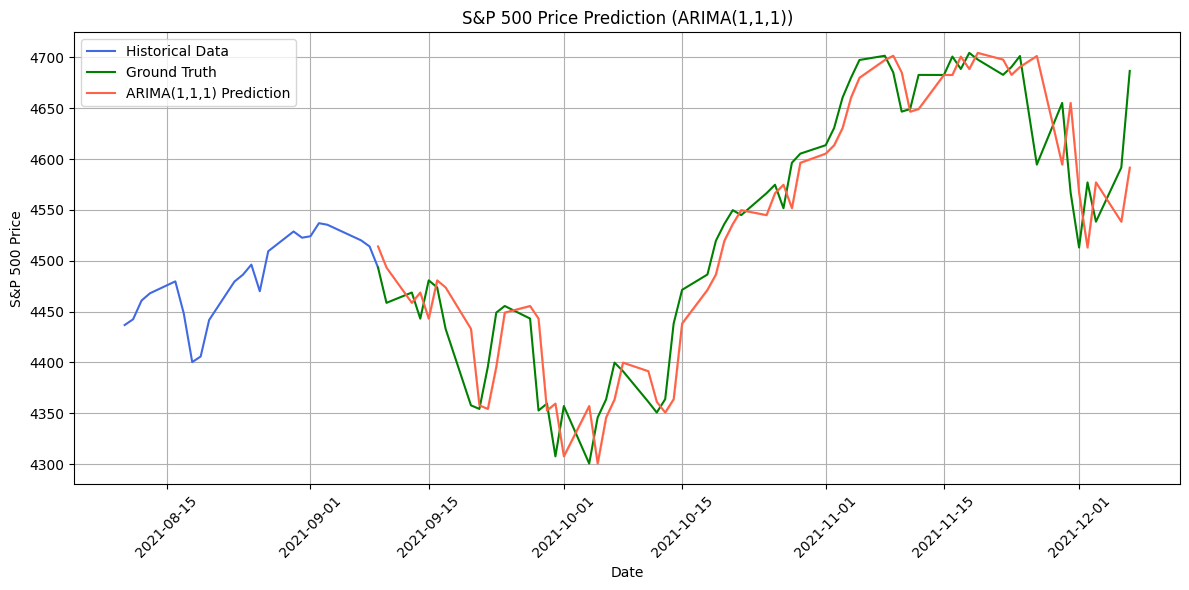

In [58]:
import pandas as pd
import numpy as np
from typing import Dict, List, Callable
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA

# Constants
FORECAST_STEPS = 5 # Number of days to forecast
# CONTEXT_WINDOW = 5  /# Approximately 1 year of trading days

def generate_arima_forecast(context_data):
    """Generate one-step forecast with ARIMA(1,1,1)"""
    try:
        model = ARIMA(context_data, order=(1,1,1))
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=1)
        median = forecast.predicted_mean[0]
        ci = forecast.conf_int(alpha=0.2).values[0]
        return ci[0], median, ci[1]
    except:
        # Fallback for convergence errors
        last_value = context_data[-1]
        return last_value, last_value, last_value


# def generate_sliding_window_forecasts(
#     data: pd.DataFrame, 
#     start_idx: int, 
#     model_fn: Callable
# ) -> Dict[str, List]:
#     """
#     Generate sliding window forecasts using the provided model function.
    
#     Args:
#         data: DataFrame with 'Date' and 'Close' columns
#         start_idx: Starting index for forecasts
#         model_fn: Function that generates (low, median, high) forecasts
        
#     Returns:
#         Dictionary containing forecast results and dates
#     """
#     all_forecasts = {
#         'median': [], 'low': [], 'high': [], 'dates': []
#     }
    
#     try:
#         for i in range(FORECAST_STEPS):
#             current_idx = start_idx + i
#             context_start = current_idx - CONTEXT_WINDOW
            
#             # Validate index bounds
#             if context_start < 0:
#                 raise ValueError("Insufficient historical data")
                
#             # Get context window
#             context_data = data['Close'].iloc[context_start:current_idx].values
            
#             # Generate and validate forecast
#             try:
#                 low, median, high = model_fn(context_data)
#                 if any(np.isnan([low, median, high])):
#                     raise ValueError("Model produced NaN values")
#             except Exception as e:
#                 print(f"Forecast failed at step {i}: {str(e)}")
#                 break
                
#             # Store results
#             all_forecasts['median'].append(median)
#             all_forecasts['low'].append(low)
#             all_forecasts['high'].append(high)
#             all_forecasts['dates'].append(data['Date'].iloc[current_idx])
            
#     except Exception as e:
#         print(f"Error in forecast generation: {str(e)}")
        
#     return all_forecasts

def generate_expanding_window_forecasts(data, start_idx, model_fn):
    all_forecasts = {
        'median': [], 'low': [], 'high': [], 'dates': []
    }
    
    for i in range(FORECAST_STEPS):
        current_idx = start_idx + i
        # Use all available data up to current point
        context_data = data['Close'].iloc[:current_idx].values
        
        # Generate forecast
        low, median, high = model_fn(context_data)
        
        # Store results
        all_forecasts['median'].append(median)
        all_forecasts['low'].append(low)
        all_forecasts['high'].append(high)
        all_forecasts['dates'].append(data['Date'].iloc[current_idx])
    
    return all_forecasts

def plot_forecast_arima(
    data: pd.DataFrame, 
    start_idx: int, 
    forecasts: Dict[str, List],
    title: str = 'S&P 500 Price Prediction'
) -> None:
    """
    Visualize forecasts with confidence intervals.
    
    Args:
        data: DataFrame with historical data
        start_idx: Starting index for forecasts
        forecasts: Dictionary containing forecast results
        title: Plot title
    """
    plt.figure(figsize=(12, 6))
    
    # Plot historical context
    context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx + 1]
    plt.plot(context_data['Date'], context_data['Close'], 
            color='royalblue', label='Historical Data')
    
    # Plot actual prices if available
    actual_data = data.iloc[start_idx:start_idx + FORECAST_STEPS]
    if len(actual_data) > 0:
        plt.plot(actual_data['Date'], actual_data['Close'], 
                color='green', label='Ground Truth')
    
    # Convert forecast data to numpy arrays and ensure they're 1-dimensional
    forecast_dates = np.array(forecasts['dates'])
    forecast_median = np.array(forecasts['median']).flatten()
    forecast_low = np.array(forecasts['low']).flatten()
    forecast_high = np.array(forecasts['high']).flatten()
    
    # Plot predictions with confidence interval
    plt.plot(forecast_dates, forecast_median,
            color='tomato', label='ARIMA(1,1,1) Prediction')
    plt.fill_between(forecast_dates,
                    forecast_low, forecast_high,
                    color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title(f'{title} (ARIMA(1,1,1))')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
def main():
    # Load and prepare data
    sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
    sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])
    
    # Set forecast start date
    target_date = pd.Timestamp('2021-09-09')
    start_idx = sp500_d[sp500_d['Date'] <= target_date].index[-1]
    
    # Validate sufficient history
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")
        
    # Generate forecasts
    arima_forecasts = generate_expanding_window_forecasts(
        sp500_d, start_idx, generate_arima_forecast
    )
    
    insample_values = sp500_d['Close'].iloc[start_idx - CONTEXT_WINDOW:start_idx].values

    # Calculate and display metrics
    if len(arima_forecasts['median']) > 0:
        actual_values = sp500_d['Close'].iloc[
            start_idx:start_idx + len(arima_forecasts['median'])
        ].values
        arima_metrics = calculate_metrics(
            actual_values, 
            arima_forecasts['median'],
            insample=insample_values
            )
        
        print("\nARIMA(1,1,1) Forecast Metrics:")
        for metric, value in arima_metrics.items():
            if value is not None:
                print(f"{metric}: {value:.4f}")
            else:
                print(f"{metric}: N/A")
                
        # Plot results
        plot_forecast_arima(sp500_d, start_idx, arima_forecasts)

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np
from typing import Dict, List
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Constants
FORECAST_STEPS = 30       # Prediction window size
CONTEXT_WINDOW = 252      # Initial training window (1 year of trading days)
CONFIDENCE_ALPHA = 0.2    # 80% confidence interval

def generate_arima_forecast(context_data: np.ndarray) -> tuple:
    """Generate one-step forecast with ARIMA(1,1,1)"""
    try:
        model = ARIMA(context_data, order=(1,1,1))
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=1)
        median = forecast.predicted_mean[0]
        ci = forecast.conf_int(alpha=CONFIDENCE_ALPHA).values[0]
        return ci[0], median, ci[1]
    except Exception as e:
        print(f"ARIMA forecast failed: {str(e)}")
        last_value = context_data[-1]
        # Fallback with naive confidence interval
        return last_value * 0.99, last_value, last_value * 1.01

def generate_expanding_window_forecasts(
    data: pd.DataFrame, 
    start_idx: int, 
    model_fn: Callable
) -> Dict[str, List]:
    """Generate forecasts with expanding window"""
    all_forecasts = {
        'median': [], 'low': [], 'high': [], 'dates': []
    }
    
    # Initialize with initial training window
    current_window = data['Close'].iloc[start_idx - CONTEXT_WINDOW:start_idx].values
    
    for i in range(FORECAST_STEPS):
        try:
            # Generate forecast
            low, median, high = model_fn(current_window)
            
            # Validate results
            if any(np.isnan([low, median, high])):
                raise ValueError("NaN values in forecast")
                
            # Store forecasts
            all_forecasts['median'].append(median)
            all_forecasts['low'].append(low)
            all_forecasts['high'].append(high)
            all_forecasts['dates'].append(data['Date'].iloc[start_idx + i])
            
            # Expand window with new observation (if available)
            if start_idx + i < len(data):
                current_window = np.append(current_window, data['Close'].iloc[start_idx + i])
                
        except Exception as e:
            print(f"Forecast failed at step {i}: {str(e)}")
            break
            
    return all_forecasts

def calculate_metrics(actual: np.ndarray, predicted: np.ndarray) -> Dict[str, float]:
    """Calculate evaluation metrics"""
    return {
        'MAE': mean_absolute_error(actual, predicted),
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'MAPE': np.mean(np.abs((actual - predicted) / actual)) * 100
    }

def plot_forecast_arima(
    data: pd.DataFrame, 
    start_idx: int, 
    forecasts: Dict[str, List]
) -> None:
    """Visualize forecasts with confidence intervals"""
    plt.figure(figsize=(12, 6))
    
    # Historical data
    historical = data.iloc[start_idx - CONTEXT_WINDOW:start_idx]
    plt.plot(historical['Date'], historical['Close'], 
            'b-', label='Historical Data')
    
    # Actual values (if available)
    actual_dates = data['Date'].iloc[start_idx:start_idx + FORECAST_STEPS]
    actual_values = data['Close'].iloc[start_idx:start_idx + FORECAST_STEPS]
    plt.plot(actual_dates, actual_values, 'g-', label='Actual Prices')
    
    # Forecasts
    forecast_dates = pd.to_datetime(forecasts['dates'])
    plt.plot(forecast_dates, forecasts['median'], 'r--', label='ARIMA Forecast')
    plt.fill_between(forecast_dates,
                    forecasts['low'], forecasts['high'],
                    color='red', alpha=0.2)
    
    plt.title(f'S&P 500 Price Forecast (ARIMA(1,1,1) - Expanding Window)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main():
    # Load your data - replace with actual data loading
    # Example:
    # data = pd.read_csv('sp500.csv', parse_dates=['Date'])
    data = snp500_daily.reset_index()[["Date", "Close"]]
    data['Date'] = pd.to_datetime(data['Date'])
    
    # Set forecast start point
    target_date = pd.Timestamp('2021-09-09')
    start_idx = data[data['Date'] <= target_date].index[-1]
    
    # Validate indices
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of historical data")
    if start_idx + FORECAST_STEPS > len(data):
        print("Warning: Forecast period exceeds available data")
    
    # Generate forecasts
    forecasts = generate_expanding_window_forecasts(
        data, start_idx, generate_arima_forecast
    )
    
    # Calculate metrics
    actual = data['Close'].iloc[start_idx:start_idx + len(forecasts['median'])].values
    metrics = calculate_metrics(actual, np.array(forecasts['median']))
    
    print("\nARIMA(1,1,1) Forecast Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}{'%' if 'MAPE' in metric else ''}")
    
    # Plot results
    plot_forecast_arima(data, start_idx, forecasts)

if __name__ == "__main__":
    main()


ARIMA Metrics: {'MAE': 35.565316659537636, 'MSE': 1819.4710872520675, 'RMSE': 42.65525861194687, 'Z-NormalizedMAE': 0.3517150396641515, 'Z-NormalizedMSE': 0.1779400376584113, 'Z-NormalizedRMSE': 0.42182939401896985, 'MAPE': 0.8942917831448859, 'SMAPE': 0.8947635416463805, 'MASE': nan, 'DirectionalAccuracy': 43.39622641509434}
Chronos Metrics: {'MAE': 36.78744652157738, 'MSE': 1961.7720415861834, 'RMSE': 44.29189589062748, 'Z-NormalizedMAE': 0.3638010125522006, 'Z-NormalizedMSE': 0.19185673979808784, 'Z-NormalizedRMSE': 0.43801454290706815, 'MAPE': 0.9266977147103265, 'SMAPE': 0.925736215721035, 'MASE': nan, 'DirectionalAccuracy': 48.148148148148145}


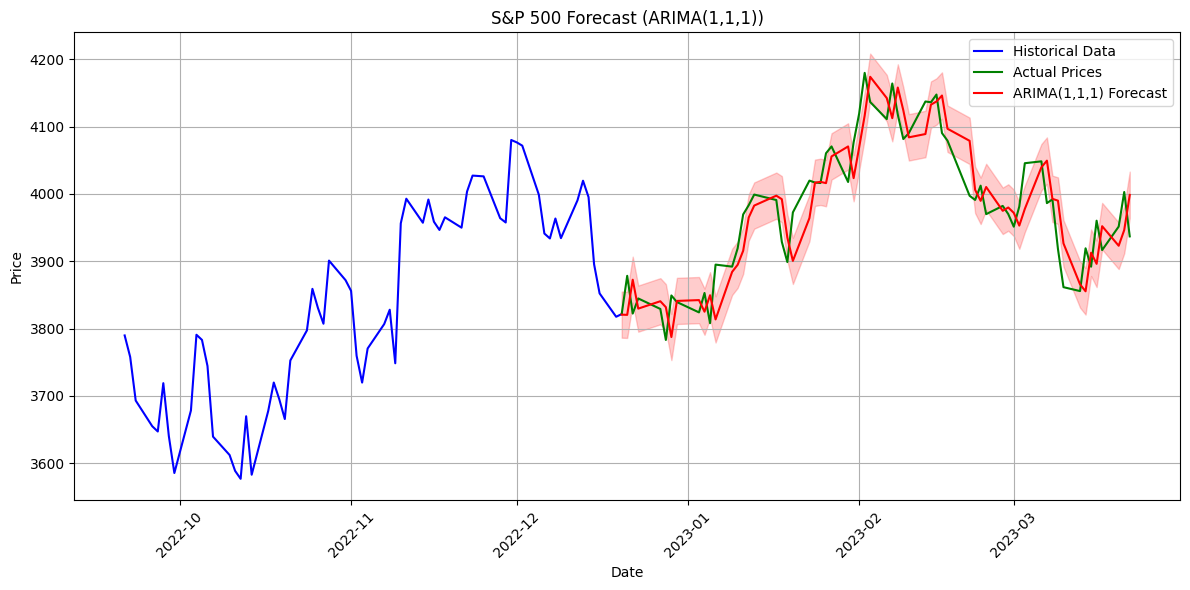

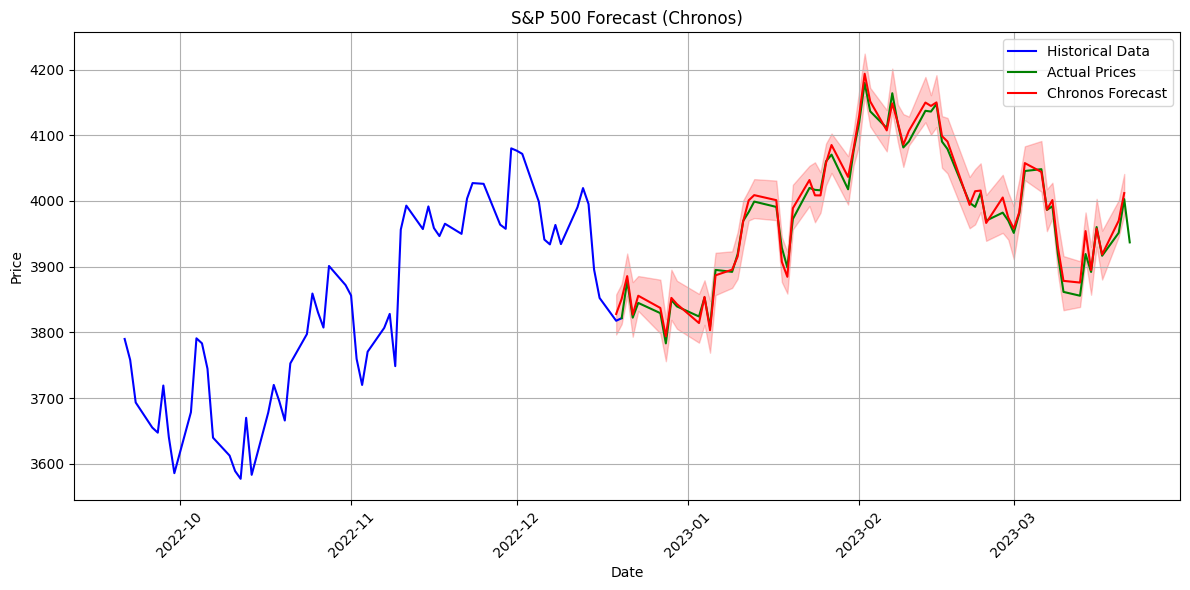

In [25]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler
from typing import Dict, List

from utils.metrics import calculate_metrics

# Shared Constants
CONTEXT_WINDOW = 378       # 3 months trading days
FORECAST_STEPS = 63     # Prediction horizon
CONFIDENCE_ALPHA = 0.2    # 80% confidence interval

# ======================
# ARIMA Implementation (Fixed for Fair Comparison)
# ======================
class ARIMAPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def generate_single_forecast(self, context_data, full_history):
        """ARIMA(1,1,1) one-step forecast with expanding window"""
        try:
            # Fit model on entire history up to this point (expanding window)
            scaled_history = self.scaler.transform(full_history.reshape(-1, 1)).flatten()
            model = ARIMA(scaled_history, order=(1,1,1))
            model_fit = model.fit()
            
            # But only use last CONTEXT_WINDOW points for prediction
            # This ensures fair comparison with Chronos input size
            scaled_context = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            
            # One-step forecast
            forecast = model_fit.get_forecast(steps=1)
            
            # Inverse transform
            median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
            ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
            return ci[0][0], median, ci[0][1]
        except Exception as e:
            raise e
    
    def sliding_window_forecast(self, data, start_idx):
        """Multiple one-step forecasts with expanding window fit but fixed context"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        # Initial fit of scaler on first context window (like Chronos)
        initial_context = data['Close'].iloc[start_idx-CONTEXT_WINDOW:start_idx].values
        self.scaler.fit(initial_context.reshape(-1, 1))
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = current_idx - CONTEXT_WINDOW
            
            # Get context window (same size as Chronos)
            context_data = data['Close'].iloc[context_start:current_idx].values
            
            # Get full history for ARIMA fit (expanding window)
            full_history = data['Close'].iloc[:current_idx].values
            
            # Generate forecast
            low, median, high = self.generate_single_forecast(context_data, full_history)
            
            forecasts['dates'].append(data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation (Corrected)
# ======================
class ChronosPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-large",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        try:
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            context = torch.tensor(scaled_data, dtype=torch.bfloat16)
            
            forecast = self.pipeline.predict(context, 1)
            forecast_np = forecast[0].cpu().numpy()
            
            forecast_original = self.scaler.inverse_transform(
                forecast_np.reshape(-1, 1)
            )
            return (
                np.quantile(forecast_original, 0.1).item(),
                np.quantile(forecast_original, 0.5).item(),
                np.quantile(forecast_original, 0.9).item()
            )
        except Exception as e:
            print(f"Chronos error: {str(e)}")
            last_val = context_data[-1]
            return last_val*0.99, last_val, last_val*1.01

    def sliding_window_forecast(self, data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        initial_context = data['Close'].iloc[start_idx-CONTEXT_WINDOW:start_idx].values
        self.scaler.fit(initial_context.reshape(-1, 1))
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = current_idx - CONTEXT_WINDOW
            context_data = data['Close'].iloc[context_start:current_idx].values
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(data['Date'].iloc[current_idx - 1])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Plotting & Execution (Unchanged)
# ======================
def plot_individual_forecast(data, start_idx, forecasts, model_name):
    plt.figure(figsize=(12, 6))
    historical = data.iloc[start_idx-63:start_idx + 1]
    plt.plot(historical['Date'], historical['Close'], 'b-', label='Historical Data')
    
    actual_dates = data['Date'].iloc[start_idx:start_idx+FORECAST_STEPS]
    actual_values = data['Close'].iloc[start_idx:start_idx+FORECAST_STEPS]
    plt.plot(actual_dates, actual_values, 'g-', label='Actual Prices')
    
    forecast_dates = pd.to_datetime(forecasts['dates'])
    plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
    plt.fill_between(forecast_dates, forecasts['low'], forecasts['high'], color='red', alpha=0.2)
    
    plt.title(f'S&P 500 Forecast ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main():
    data = snp500_daily
    target_date = '2022-12-19'
    start_idx = data[data['Date'] <= pd.Timestamp(target_date)].index[-1]
    
    # Validate indices
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")
    
    arima = ARIMAPredictor()
    chronos = ChronosPredictor()
    
    # arima_preds = arima.sliding_window_forecast(data, start_idx)
    arima_preds = arima.sliding_window_forecast(data, start_idx)
    chronos_preds = chronos.sliding_window_forecast(data, start_idx)
    
    # Calculate metrics
    actual = data['Close'].iloc[start_idx:start_idx+FORECAST_STEPS].values
    print("\nARIMA Metrics:", calculate_metrics(actual, arima_preds['median']))
    print("Chronos Metrics:", calculate_metrics(actual, chronos_preds['median']))
    
    # Plot results
    plot_individual_forecast(data, start_idx, arima_preds, "ARIMA(1,1,1)")
    plot_individual_forecast(data, start_idx, chronos_preds, "Chronos")

if __name__ == "__main__":
    main()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3

Trial 0 metrics: {'MAE': 32.71737816220238, 'MSE': 1698.8777999196734, 'RMSE': 41.21744533470838, 'Z-NormalizedMAE': 0.5981702138835854, 'Z-NormalizedMSE': 0.5678775766823699, 'Z-NormalizedRMSE': 0.7535765234416277, 'MAPE': 0.7470257386146534, 'SMAPE': 0.744390963716885, 'MASE': 2.3752056034896083, 'DirectionalAccuracy': 47.368421052631575}
Trial 1 metrics: {'MAE': 32.257196335565474, 'MSE': 1702.0906124711037, 'RMSE': 41.25640086666678, 'Z-NormalizedMAE': 0.589756732207271, 'Z-NormalizedMSE': 0.5689515116093713, 'Z-NormalizedRMSE': 0.7542887455141906, 'MAPE': 0.7364628947793141, 'SMAPE': 0.7338693000681081, 'MASE': 2.3417974725619652, 'DirectionalAccuracy': 47.368421052631575}
Trial 2 metrics: {'MAE': 33.628301711309526, 'MSE': 1767.5776158741542, 'RMSE': 42.04256909222073, 'Z-NormalizedMAE': 0.6148245842765807, 'Z-NormalizedMSE': 0.5908416091775853, 'Z-NormalizedRMSE': 0.7686622204698143, 'MAPE': 0.7674026764258954, 'SMAPE': 0.7648671108255922, 'MASE': 2.441336535725784, 'Directional

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3

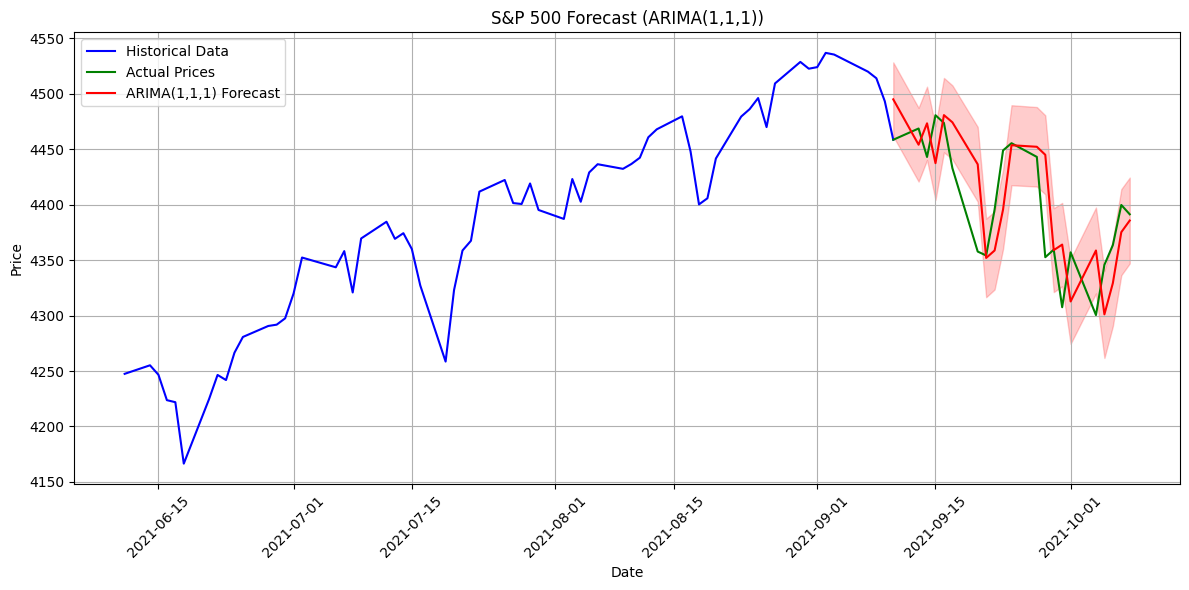

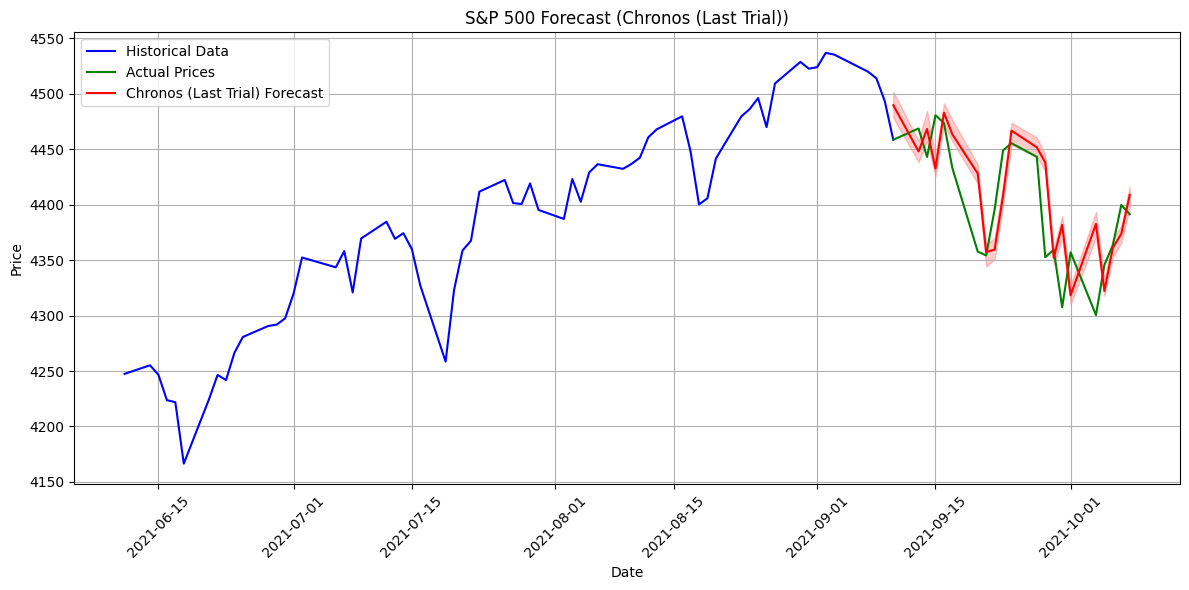

In [26]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler

from utils.metrics import calculate_metrics
from data.snp500 import snp500_daily

CONTEXT_WINDOW = 63
FORECAST_STEPS = 21     
CONFIDENCE_ALPHA = 0.2

# ======================
# ARIMA Implementation
# ======================
class ARIMAPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast with expanding window"""
        try:
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            
            model = ARIMA(scaled_data, order=(1,1,1))
            model_fit = model.fit()
            forecast = model_fit.get_forecast(steps=1)
            
            median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
            ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
            return ci[0][0], median, ci[0][1]
        except Exception as e:
            raise e
    
    def expanding_window_forecast(self, data, start_idx):
        """Multiple one-step forecasts with expanding window starting from CONTEXT_WINDOW"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        # Initial fit of scaler on first context window (like Chronos)
        initial_context = data['Close'].iloc[start_idx-CONTEXT_WINDOW:start_idx].values
        self.scaler.fit(initial_context.reshape(-1, 1))
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            
            # Expanding window starting from initial context window
            context_start = start_idx - CONTEXT_WINDOW  # Fixed starting point
            context_data = data['Close'].iloc[context_start:current_idx].values  # Growing window
            
            # Generate forecast
            low, median, high = self.generate_single_forecast(context_data)
            
            forecasts['dates'].append(data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts
    
# ======================
# Chronos Implementation (Corrected)
# ======================
class ChronosPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-large",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        try:
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            context = torch.tensor(scaled_data, dtype=torch.bfloat16)
            
            forecast = self.pipeline.predict(context, 1)
            forecast_np = forecast[0].cpu().numpy()
            
            forecast_original = self.scaler.inverse_transform(
                forecast_np.reshape(-1, 1)
            )
            return (
                np.quantile(forecast_original, 0.1).item(),
                np.quantile(forecast_original, 0.5).item(),
                np.quantile(forecast_original, 0.9).item()
            )
        except Exception as e:
            print(f"Chronos error: {str(e)}")
            last_val = context_data[-1]
            return last_val*0.99, last_val, last_val*1.01

    def sliding_window_forecast(self, data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        initial_context = data['Close'].iloc[start_idx-CONTEXT_WINDOW:start_idx].values
        self.scaler.fit(initial_context.reshape(-1, 1))
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = current_idx - CONTEXT_WINDOW
            context_data = data['Close'].iloc[context_start:current_idx].values
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Plotting & Execution
# ======================
def plot_individual_forecast(data, start_idx, forecasts, model_name):
    plt.figure(figsize=(12, 6))
    historical = data.iloc[start_idx-63:start_idx + 1]
    plt.plot(historical['Date'], historical['Close'], 'b-', label='Historical Data')
    
    actual_dates = data['Date'].iloc[start_idx:start_idx+FORECAST_STEPS]
    actual_values = data['Close'].iloc[start_idx:start_idx+FORECAST_STEPS]
    plt.plot(actual_dates, actual_values, 'g-', label='Actual Prices')
    
    forecast_dates = pd.to_datetime(forecasts['dates'])
    plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
    plt.fill_between(forecast_dates, forecasts['low'], forecasts['high'], color='red', alpha=0.2)
    
    plt.title(f'S&P 500 Forecast ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def run_multiple_trials(data, start_idx, n_trials=10):
    # Get insample data (historical data before the forecast period)
    insample = data['Close'].iloc[:start_idx].values
    
    # ARIMA
    arima = ARIMAPredictor()
    arima_preds = arima.expanding_window_forecast(data, start_idx)
    actual = data['Close'].iloc[start_idx:start_idx+FORECAST_STEPS].values
    arima_metrics = calculate_metrics(actual, arima_preds['median'], insample=insample)
    
    # Chronos trials
    chronos_metrics_list = []
    for trial in range(n_trials):
        chronos = ChronosPredictor()
        chronos_preds = chronos.sliding_window_forecast(data, start_idx)
        chronos_metrics = calculate_metrics(actual, chronos_preds['median'], insample=insample)
        chronos_metrics_list.append(chronos_metrics)
        
        # Print individual trial metrics to verify variation
        print(f"Trial {trial} metrics:", chronos_metrics)
    
    # Calculate average and std for Chronos metrics
    chronos_avg_metrics = {}
    chronos_std_metrics = {}
    
    for metric in chronos_metrics_list[0].keys():
        values = [m[metric] for m in chronos_metrics_list]
        chronos_avg_metrics[metric] = np.mean(values)
        chronos_std_metrics[metric] = np.std(values)
    
    return arima_metrics, chronos_avg_metrics, chronos_std_metrics

def main():
    data = snp500_daily
    target_date = '2021-09-09'
    start_idx = data[data['Date'] <= pd.Timestamp(target_date)].index[-1]
    
    # Validate indices
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")
    
    # Run multiple trials
    n_trials = 10  # You can adjust this number
    arima_metrics, chronos_avg_metrics, chronos_std_metrics = run_multiple_trials(
        data, start_idx, n_trials
    )
    
    # Print results
    print("\nARIMA Metrics (Deterministic):")
    for metric, value in arima_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nChronos Metrics (Average ± Std over {n_trials} runs):")
    for metric in chronos_avg_metrics:
        print(f"{metric}: {chronos_avg_metrics[metric]:.4f} ± {chronos_std_metrics[metric]:.4f}")
    
    # For visualization, we can use the last trial's predictions
    arima = ARIMAPredictor()
    chronos = ChronosPredictor()
    
    arima_preds = arima.expanding_window_forecast(data, start_idx)
    chronos_preds = chronos.sliding_window_forecast(data, start_idx)
    
    # Plot results
    plot_individual_forecast(data, start_idx, arima_preds, "ARIMA(1,1,1)")
    plot_individual_forecast(data, start_idx, chronos_preds, "Chronos (Last Trial)")

if __name__ == "__main__":
    main()

Trial 0 metrics: {'MAE': 37.086276584201386, 'MSE': 1884.4569858437965, 'RMSE': 43.410332708282674, 'Z-NormalizedMAE': 0.3667562238985463, 'Z-NormalizedMSE': 0.18429550729115077, 'Z-NormalizedRMSE': 0.42929652606461977, 'MAPE': 0.9322090136919354, 'SMAPE': 0.9323363004690521, 'MASE': nan, 'DirectionalAccuracy': 46.15384615384615}
Trial 1 metrics: {'MAE': 38.24778529575893, 'MSE': 2005.6863836657906, 'RMSE': 44.78489012675805, 'Z-NormalizedMAE': 0.3782426978266834, 'Z-NormalizedMSE': 0.19615146024632055, 'Z-NormalizedRMSE': 0.4428898963019145, 'MAPE': 0.961678974827364, 'SMAPE': 0.9630821874188604, 'MASE': nan, 'DirectionalAccuracy': 46.15384615384615}
Trial 2 metrics: {'MAE': 37.21010044642857, 'MSE': 1967.6485647918687, 'RMSE': 44.35818486809248, 'Z-NormalizedMAE': 0.3679807515762135, 'Z-NormalizedMSE': 0.19243145009046156, 'Z-NormalizedRMSE': 0.43867009254160644, 'MAPE': 0.9358881975491586, 'SMAPE': 0.9362791747741825, 'MASE': nan, 'DirectionalAccuracy': 48.97959183673469}
Trial 3 me

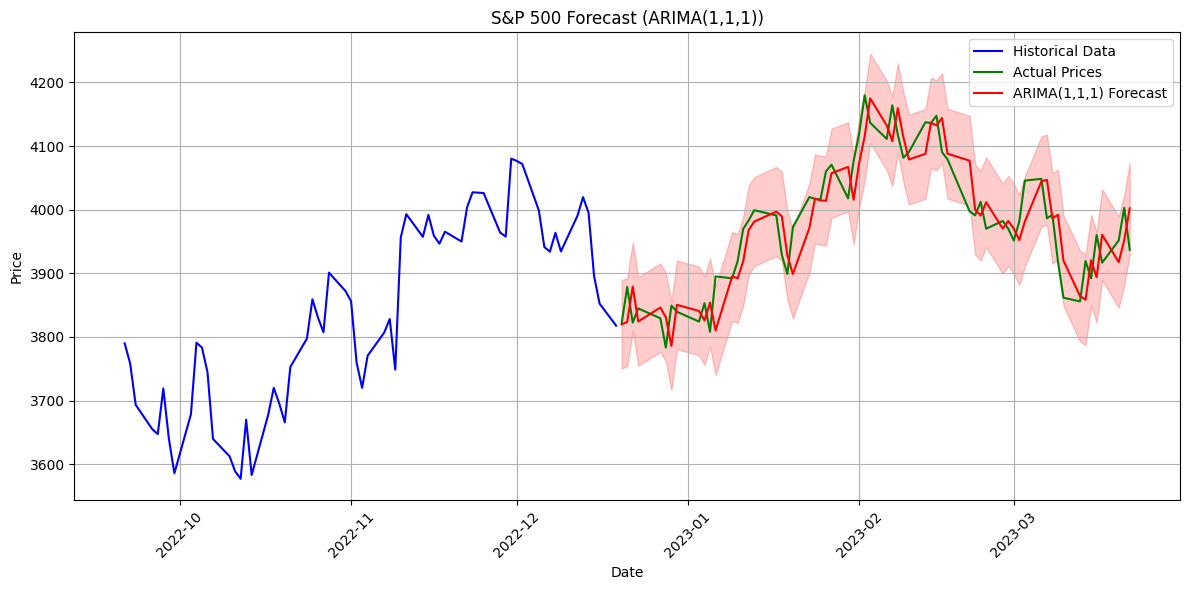

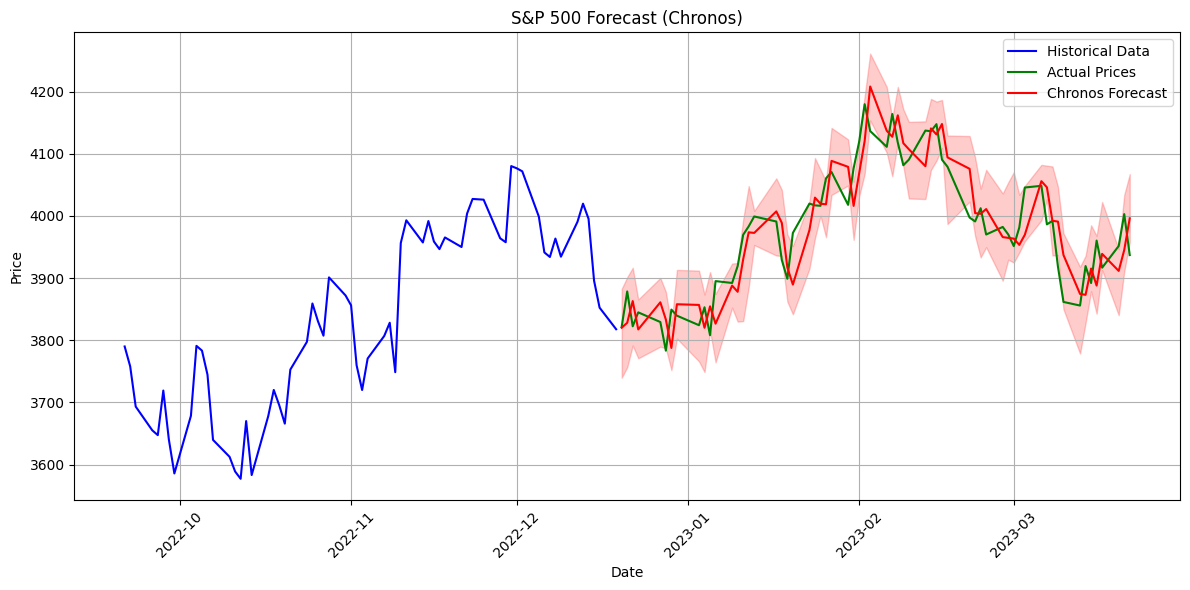

In [16]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler

from utils.metrics import calculate_metrics

# Updated Constants
CONTEXT_WINDOW = 378
FORECAST_STEPS = 63
CONFIDENCE_ALPHA = 0.2
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1

# ======================
# Data Preparation
# ======================
def prepare_data(data):
    """Split data into indices for train/val/test sets"""
    n = len(data)
    train_end = int(TRAIN_RATIO * n)
    val_end = train_end + int(VAL_RATIO * n)
    return train_end, val_end

# ======================
# ARIMA Implementation (Fixed Scaling)
# ======================
class ARIMAPredictor:
    def __init__(self, train_data):
        self.scaler = StandardScaler()
        self.scaler.fit(train_data.reshape(-1, 1))  # Fit once on training data
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast"""
        try:
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            
            model = ARIMA(scaled_data, order=(1,1,1))
            model_fit = model.fit()
            forecast = model_fit.get_forecast(steps=1)
            
            median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
            ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
            return ci[0][0], median, ci[0][1]
        except Exception as e:
            raise e
    
    def expanding_window_forecast(self, full_data, start_idx):
        """Forecast with expanding window using fixed scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            # Ensure we have at least 2 samples for differencing
            if len(context_data) < 2:
                raise ValueError(f"Insufficient context data (need ≥2 samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            # Fix date alignment
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation (Fixed Scaling)
# ======================
class ChronosPredictor:
    def __init__(self, train_data):
        self.scaler = StandardScaler()
        self.scaler.fit(train_data.reshape(-1, 1))
        self.pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-large",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        try:
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            context = torch.tensor(scaled_data, dtype=torch.bfloat16)
            
            forecast = self.pipeline.predict(context, 1)
            forecast_np = forecast[0].cpu().numpy()
            
            forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
            return (
                np.quantile(forecast_original, 0.1).item(),
                np.quantile(forecast_original, 0.5).item(),
                np.quantile(forecast_original, 0.9).item()
            )
        except Exception as e:
            print(f"Chronos error: {str(e)}")
            last_val = self.scaler.inverse_transform([[context_data[-1]]])[0][0]
            return last_val*0.99, last_val, last_val*1.01

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < CONTEXT_WINDOW:
                raise ValueError(f"Need at least {CONTEXT_WINDOW} samples for context")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

def plot_individual_forecast(data, start_idx, forecasts, model_name):
    """Fixed plotting function with proper index alignment"""
    plt.figure(figsize=(12, 6))
    
    # Historical data (3 months before forecast start)
    historical_start = max(0, start_idx - 63)
    historical = data.iloc[historical_start:start_idx + 1]
    plt.plot(historical['Date'], historical['Close'], 'b-', label='Historical Data')
    
    # Actual values with CORRECTED indices
    actual_dates = data['Date'].iloc[start_idx:start_idx+FORECAST_STEPS]
    actual_values = data['Close'].iloc[start_idx:start_idx+FORECAST_STEPS]
    plt.plot(actual_dates, actual_values, 'g-', label='Actual Prices')
    
    # Forecasts with alignment validation
    forecast_dates = forecasts['dates']
    if len(forecast_dates) != FORECAST_STEPS:
        raise ValueError(f"Expected {FORECAST_STEPS} forecast dates, got {len(forecast_dates)}")
    
    if model_name == "ARIMA(1,1,1)":
        plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
    else:     
        plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
        plt.fill_between(forecast_dates, forecasts['low'], forecasts['high'], color='red', alpha=0.2)
    
    plt.title(f'S&P 500 Forecast ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def run_multiple_trials(full_data, train_end, val_end, n_trials=10):
    """Updated to return predictions for plotting"""
    train_data = full_data['Close'].iloc[:train_end].values
    arima = ARIMAPredictor(train_data)
    chronos = ChronosPredictor(train_data)
    
    test_start = val_end
    actual = full_data['Close'].iloc[test_start:test_start+FORECAST_STEPS].values
    
    # ARIMA Forecast
    arima_preds = arima.expanding_window_forecast(full_data, test_start)
    arima_metrics = calculate_metrics(actual, arima_preds['median'])
    
    # Chronos trials
    chronos_metrics_list = []
    chronos_preds = None
    for trial in range(n_trials):
        chronos_preds = chronos.sliding_window_forecast(full_data, test_start)
        chronos_metrics = calculate_metrics(actual, chronos_preds['median'])
        chronos_metrics_list.append(chronos_metrics)
        print(f"Trial {trial} metrics:", chronos_metrics)
    
    # Calculate statistics
    chronos_avg_metrics = {metric: np.mean([m[metric] for m in chronos_metrics_list]) 
                          for metric in chronos_metrics_list[0]}
    chronos_std_metrics = {metric: np.std([m[metric] for m in chronos_metrics_list]) 
                          for metric in chronos_metrics_list[0]}
    
    return arima_metrics, chronos_avg_metrics, chronos_std_metrics, arima_preds, chronos_preds

def main():
    data = snp500_daily.sort_values('Date')
    train_end, val_end = prepare_data(data)
    test_start = val_end
    
    # Run trials and get predictions
    results = run_multiple_trials(data, train_end, val_end, 10)
    arima_metrics, chronos_avg_metrics, chronos_std_metrics, arima_preds, chronos_preds = results
    
    # Print results
    print("\nARIMA Metrics:")
    for metric, value in arima_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print(f"\nChronos Metrics (Average ± Std over 10 runs):")
    for metric in chronos_avg_metrics:
        print(f"{metric}: {chronos_avg_metrics[metric]:.4f} ± {chronos_std_metrics[metric]:.4f}")
    
    # Plot results with validated indices
    plot_individual_forecast(data, test_start, arima_preds, "ARIMA(1,1,1)")
    plot_individual_forecast(data, test_start, chronos_preds, "Chronos")

if __name__ == "__main__":
    main()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3


Trial 0
Global scaling metrics: {'MAE': 41.48968505859375, 'MSE': 2576.768704821169, 'RMSE': 50.76188240029293, 'Z-NormalizedMAE': 1.7379864749238536, 'Z-NormalizedMSE': 4.521556330844168, 'Z-NormalizedRMSE': 2.126395149271219, 'MAPE': 1.0796625159296516, 'SMAPE': 1.0837337977636283, 'MASE': 0.8571248150936912, 'DirectionalAccuracy': 11.11111111111111}
Context scaling metrics: {'MAE': 35.85260009765625, 'MSE': 1763.6190346106887, 'RMSE': 41.9954644528512, 'Z-NormalizedMAE': 1.5018512185036135, 'Z-NormalizedMSE': 3.0946909577957897, 'Z-NormalizedRMSE': 1.7591733734330424, 'MAPE': 0.9345886273861884, 'SMAPE': 0.9349101630483293, 'MASE': 0.7406697155192442, 'DirectionalAccuracy': 33.33333333333333}

ARIMA Global Scaling Metrics:
MAE: 30.3361
MSE: 1253.2186
RMSE: 35.4008
Z-NormalizedMAE: 1.2708
Z-NormalizedMSE: 2.1991
Z-NormalizedRMSE: 1.4829
MAPE: 0.7913
SMAPE: 0.7909
MASE: 0.6267
DirectionalAccuracy: 25.0000

ARIMA Context Window Scaling Metrics:
MAE: 30.9786
MSE: 1316.6310
RMSE: 36.285

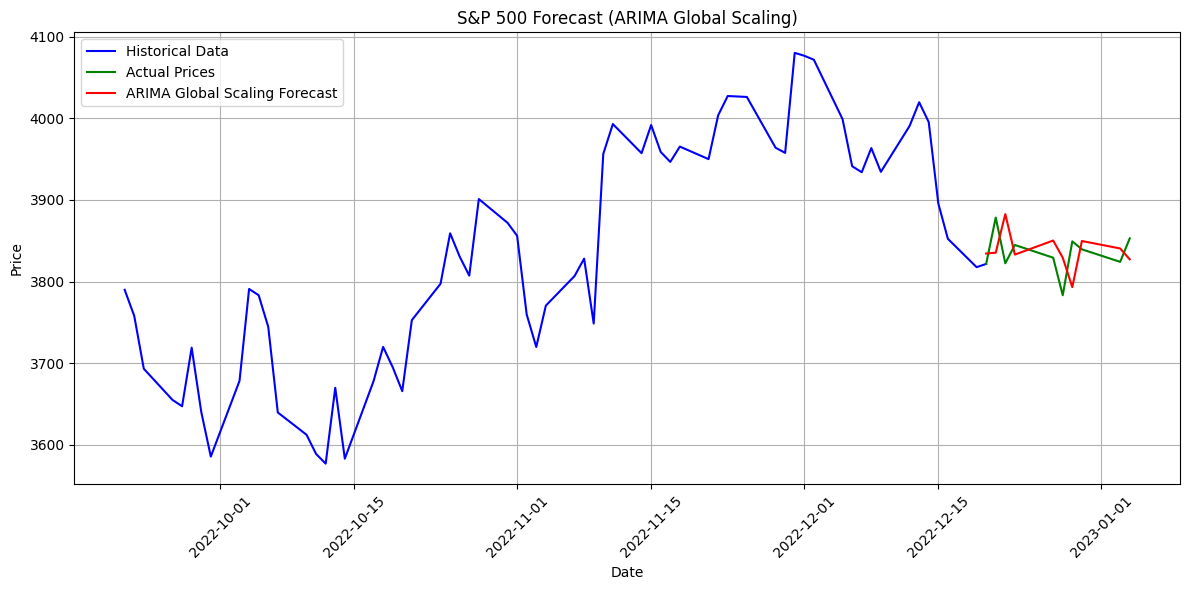

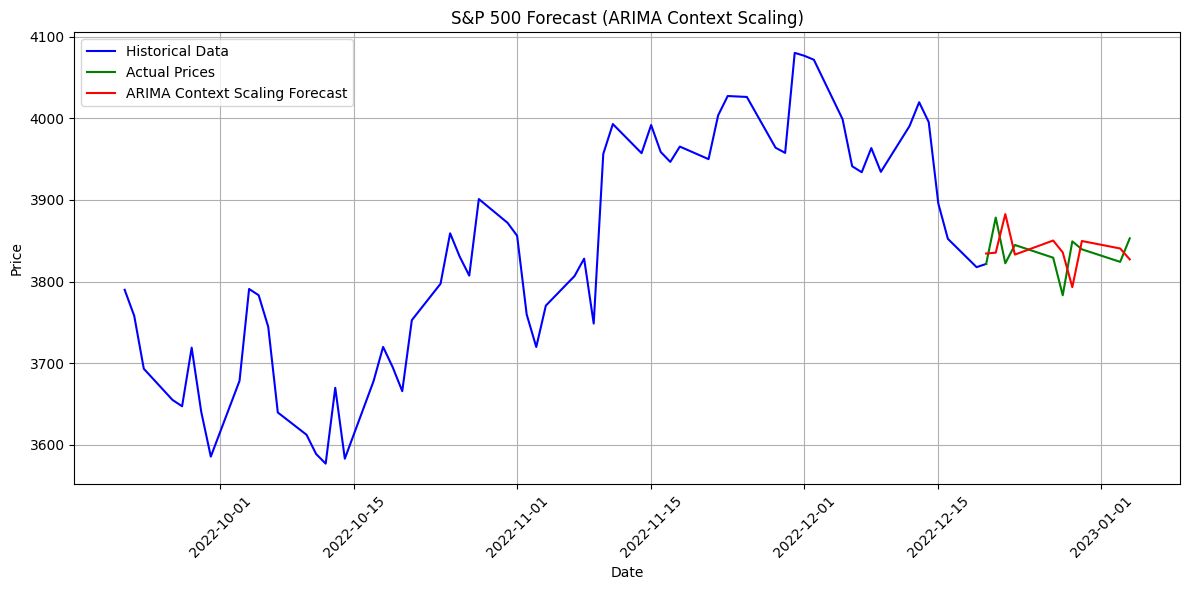

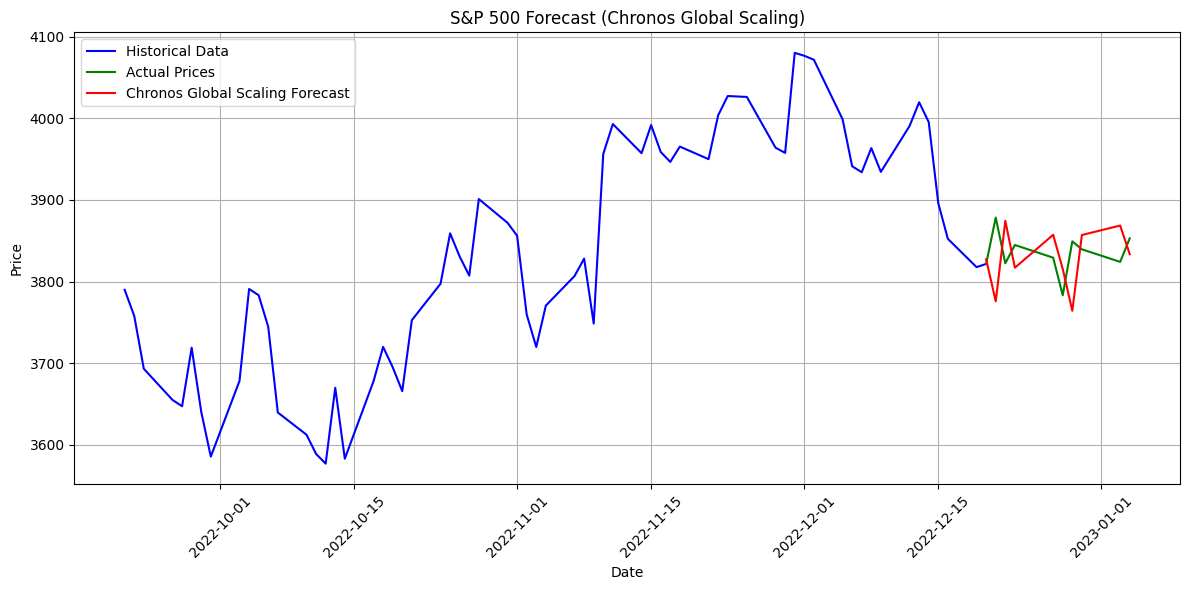

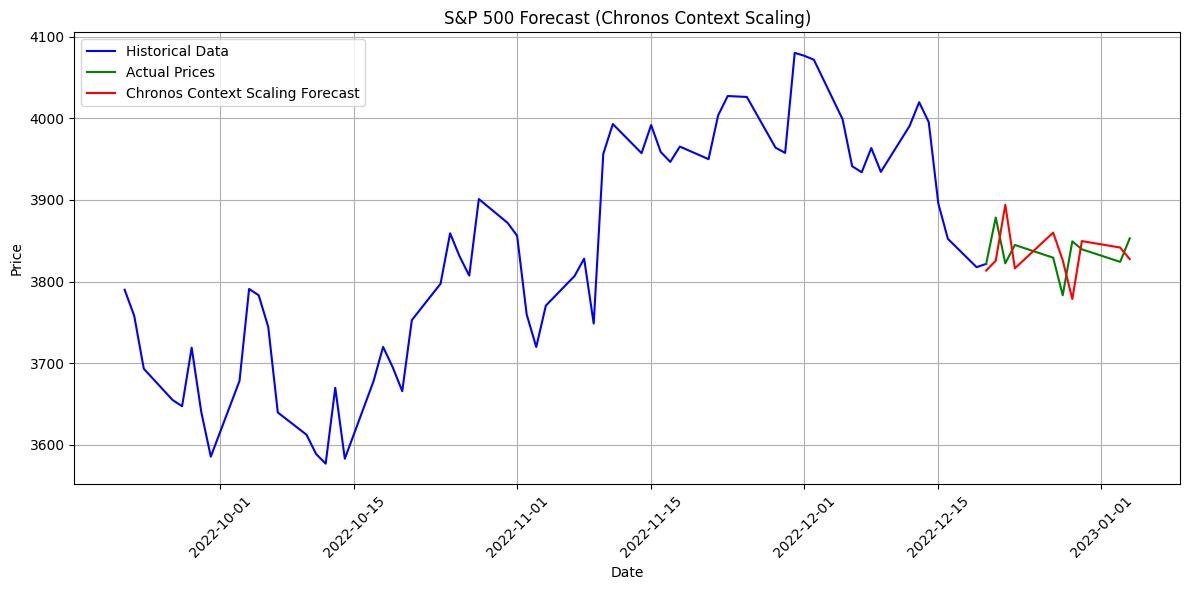

In [77]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler

from utils.metrics import calculate_metrics

# Updated Constants
CONTEXT_WINDOW = 63
FORECAST_STEPS = 10
CONFIDENCE_ALPHA = 0.2
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1

# ======================
# Data Preparation
# ======================
def prepare_data(data):
    """Split data into indices for train/val/test sets"""
    n = len(data)
    train_end = int(TRAIN_RATIO * n)
    val_end = train_end + int(VAL_RATIO * n)
    return train_end, val_end

# ======================
# ARIMA Implementation (Fixed Scaling)
# ======================
class ARIMAPredictor:
    def __init__(self, train_data):
        self.scaler = StandardScaler()
        self.scaler.fit(train_data.reshape(-1, 1))  # Fit once on training data
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast"""
        try:
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            
            model = ARIMA(scaled_data, order=(1,1,1))
            model_fit = model.fit()
            forecast = model_fit.get_forecast(steps=1)
            
            median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
            ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
            return ci[0][0], median, ci[0][1]
        except Exception as e:
            raise e
    
    def expanding_window_forecast(self, full_data, start_idx):
        """Forecast with expanding window using fixed scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            # Ensure we have at least 2 samples for differencing
            if len(context_data) < 2:
                raise ValueError(f"Insufficient context data (need ≥2 samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            # Fix date alignment
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation (Fixed Scaling)
# ======================
class ChronosPredictor:
    def __init__(self, train_data):
        self.scaler = StandardScaler()
        self.scaler.fit(train_data.reshape(-1, 1))
        self.pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-large",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        try:
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            context = torch.tensor(scaled_data, dtype=torch.bfloat16)
            
            forecast = self.pipeline.predict(context, 1)
            forecast_np = forecast[0].cpu().numpy()
            
            forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
            return (
                np.quantile(forecast_original, 0.1).item(),
                np.quantile(forecast_original, 0.5).item(),
                np.quantile(forecast_original, 0.9).item()
            )
        except Exception as e:
            print(f"Chronos error: {str(e)}")
            last_val = self.scaler.inverse_transform([[context_data[-1]]])[0][0]
            return last_val*0.99, last_val, last_val*1.01

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < CONTEXT_WINDOW:
                raise ValueError(f"Need at least {CONTEXT_WINDOW} samples for context")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# ARIMA Implementation with Context Window Scaling
# ======================
class ARIMAPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast with context window scaling"""
        try:
            # Fit scaler on context window
            self.scaler.fit(context_data.reshape(-1, 1))
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            
            model = ARIMA(scaled_data, order=(1,1,1))
            model_fit = model.fit()
            forecast = model_fit.get_forecast(steps=1)
            
            median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
            ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
            return ci[0][0], median, ci[0][1]
        except Exception as e:
            raise e
    
    def expanding_window_forecast(self, full_data, start_idx):
        """Forecast with expanding window using context window scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < 2:
                raise ValueError(f"Insufficient context data (need ≥2 samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation with Context Window Scaling
# ======================
class ChronosPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-large",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        try:
            # Fit scaler on context window
            self.scaler.fit(context_data.reshape(-1, 1))
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            context = torch.tensor(scaled_data, dtype=torch.bfloat16)
            
            forecast = self.pipeline.predict(context, 1)
            forecast_np = forecast[0].cpu().numpy()
            
            forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
            return (
                np.quantile(forecast_original, 0.1).item(),
                np.quantile(forecast_original, 0.5).item(),
                np.quantile(forecast_original, 0.9).item()
            )
        except Exception as e:
            print(f"Chronos error: {str(e)}")
            last_val = context_data[-1]
            return last_val*0.99, last_val, last_val*1.01

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < CONTEXT_WINDOW:
                raise ValueError(f"Need at least {CONTEXT_WINDOW} samples for context")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

def run_multiple_trials_comparison(full_data, train_end, val_end, n_trials=1, test_start=None):
    """Run trials for both global and context scaling approaches"""
    train_data = full_data['Close'].iloc[:train_end].values
    test_start = val_end
    actual = full_data['Close'].iloc[test_start:test_start+FORECAST_STEPS].values
    
    # Global scaling ARIMA
    arima_global = ARIMAPredictor(train_data)
    insample_data = full_data['Close'].iloc[test_start - CONTEXT_WINDOW:test_start].values
    arima_global_preds = arima_global.expanding_window_forecast(full_data, test_start)
    arima_global_metrics = calculate_metrics(actual, arima_global_preds['median'], insample=insample_data)
    
    # Context window scaling ARIMA
    arima_context = ARIMAPredictorContextScale()
    arima_context_preds = arima_context.expanding_window_forecast(full_data, test_start)
    arima_context_metrics = calculate_metrics(actual, arima_context_preds['median'], insample=insample_data)
    
    # Global scaling Chronos
    chronos_global = ChronosPredictor(train_data)
    chronos_global_metrics_list = []
    chronos_global_preds = None
    
    # Context window scaling Chronos
    chronos_context = ChronosPredictorContextScale()
    chronos_context_metrics_list = []
    chronos_context_preds = None
    
    for trial in range(n_trials):
        # Global scaling trial
        chronos_global_preds = chronos_global.sliding_window_forecast(full_data, test_start)
        chronos_global_metrics = calculate_metrics(actual, chronos_global_preds['median'], insample=insample_data)
        chronos_global_metrics_list.append(chronos_global_metrics)
        
        # Context window scaling trial
        chronos_context_preds = chronos_context.sliding_window_forecast(full_data, test_start)
        chronos_context_metrics = calculate_metrics(actual, chronos_context_preds['median'], insample=insample_data)
        chronos_context_metrics_list.append(chronos_context_metrics)
        
        print(f"\nTrial {trial}")
        print("Global scaling metrics:", chronos_global_metrics)
        print("Context scaling metrics:", chronos_context_metrics)
    
    # Calculate statistics for Chronos
    chronos_global_avg = {metric: np.mean([m[metric] for m in chronos_global_metrics_list]) 
                         for metric in chronos_global_metrics_list[0]}
    chronos_global_std = {metric: np.std([m[metric] for m in chronos_global_metrics_list]) 
                         for metric in chronos_global_metrics_list[0]}
    
    chronos_context_avg = {metric: np.mean([m[metric] for m in chronos_context_metrics_list]) 
                          for metric in chronos_context_metrics_list[0]}
    chronos_context_std = {metric: np.std([m[metric] for m in chronos_context_metrics_list]) 
                          for metric in chronos_context_metrics_list[0]}
    
    return (arima_global_metrics, arima_context_metrics, 
            chronos_global_avg, chronos_global_std,
            chronos_context_avg, chronos_context_std,
            arima_global_preds, arima_context_preds,
            chronos_global_preds, chronos_context_preds)


def plot_individual_forecast(data, start_idx, forecasts, model_name):
    """Fixed plotting function with proper index alignment"""
    plt.figure(figsize=(12, 6))
    
    # Historical data (3 months before forecast start)
    historical_start = max(0, start_idx - 63)
    historical = data.iloc[historical_start:start_idx + 1]
    plt.plot(historical['Date'], historical['Close'], 'b-', label='Historical Data')
    
    # Actual values with CORRECTED indices
    actual_dates = data['Date'].iloc[start_idx:start_idx+FORECAST_STEPS]
    actual_values = data['Close'].iloc[start_idx:start_idx+FORECAST_STEPS]
    plt.plot(actual_dates, actual_values, 'g-', label='Actual Prices')
    
    # Forecasts with alignment validation
    forecast_dates = forecasts['dates']
    if len(forecast_dates) != FORECAST_STEPS:
        raise ValueError(f"Expected {FORECAST_STEPS} forecast dates, got {len(forecast_dates)}")
    
    if model_name == "ARIMA Global Scaling" or "ARIMA Context Scaling":
        plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
    else:     
        plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
        plt.fill_between(forecast_dates, forecasts['low'], forecasts['high'], color='red', alpha=0.2)
    
    plt.title(f'S&P 500 Forecast ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main():
    data = snp500_daily.sort_values('Date')
    train_end, val_end = prepare_data(data)
    test_start = val_end
    
    results = run_multiple_trials_comparison(data, train_end, val_end, 1, test_start)
    (arima_global_metrics, arima_context_metrics, 
     chronos_global_avg, chronos_global_std,
     chronos_context_avg, chronos_context_std,
     arima_global_preds, arima_context_preds,
     chronos_global_preds, chronos_context_preds) = results
    
    # Print results
    print("\nARIMA Global Scaling Metrics:")
    for metric, value in arima_global_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nARIMA Context Window Scaling Metrics:")
    for metric, value in arima_context_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nChronos Global Scaling Metrics (Average ± Std):")
    for metric in chronos_global_avg:
        print(f"{metric}: {chronos_global_avg[metric]:.4f} ± {chronos_global_std[metric]:.4f}")
    
    print("\nChronos Context Window Scaling Metrics (Average ± Std):")
    for metric in chronos_context_avg:
        print(f"{metric}: {chronos_context_avg[metric]:.4f} ± {chronos_context_std[metric]:.4f}")
    
    # Plot results
    plot_individual_forecast(data, test_start, arima_global_preds, "ARIMA Global Scaling")
    plot_individual_forecast(data, test_start, arima_context_preds, "ARIMA Context Scaling")
    plot_individual_forecast(data, test_start, chronos_global_preds, "Chronos Global Scaling")
    plot_individual_forecast(data, test_start, chronos_context_preds, "Chronos Context Scaling")

if __name__ == "__main__":
    main()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Trial 0
Global scaling metrics: {'MAE': 27.675176711309526, 'MSE': 1102.6413255589348, 'RMSE': 33.20604350956215, 'Z-NormalizedMAE': 0.4767093667162038, 'Z-NormalizedMSE': 0.327160475457325, 'Z-NormalizedRMSE': 0.57197943621893, 'MAPE': 0.6370409774170555, 'SMAPE': 0.6383909160677098, 'MASE': 0.9716089640541506, 'DirectionalAccuracy': 50.0}
Context scaling metrics: {'MAE': 96.5165783110119, 'MSE': 11583.388870432264, 'RMSE': 107.62615328270478, 'Z-NormalizedMAE': 1.662513573236016, 'Z-NormalizedMSE': 3.436862851423353, 'Z-NormalizedRMSE': 1.8538777876179846, 'MAPE': 2.2269866717930658, 'SMAPE': 2.2541260509458, 'MASE': 3.388465181091026, 'DirectionalAccuracy': 50.0}

ARIMA Context Window Scaling Metrics:
MAE: 27.8415
MSE: 1102.3863
RMSE: 33.2022
Z-NormalizedMAE: 0.4796
Z-NormalizedMSE: 0.3271
Z-NormalizedRMSE: 0.5719
MAPE: 0.6398
SMAPE: 0.6419
MASE: 0.9774
DirectionalAccuracy: 50.0000

Chronos Context Window Scaling Metrics (Average ± Std):
MAE: 96.5166 ± 0.0000
MSE: 11583.3889 ± 0.00

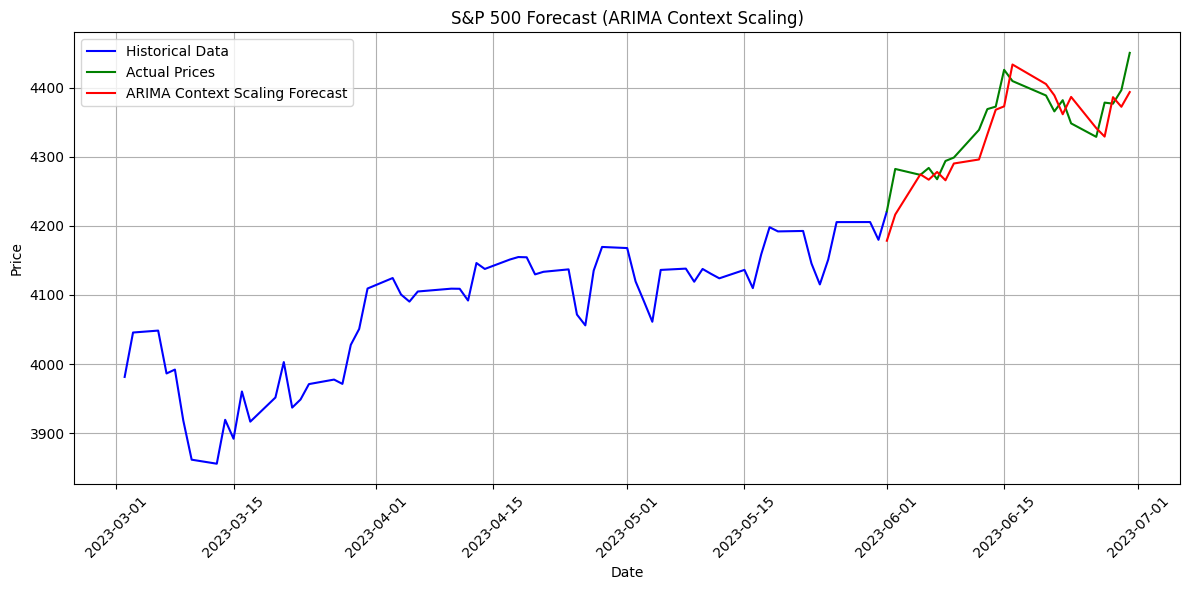

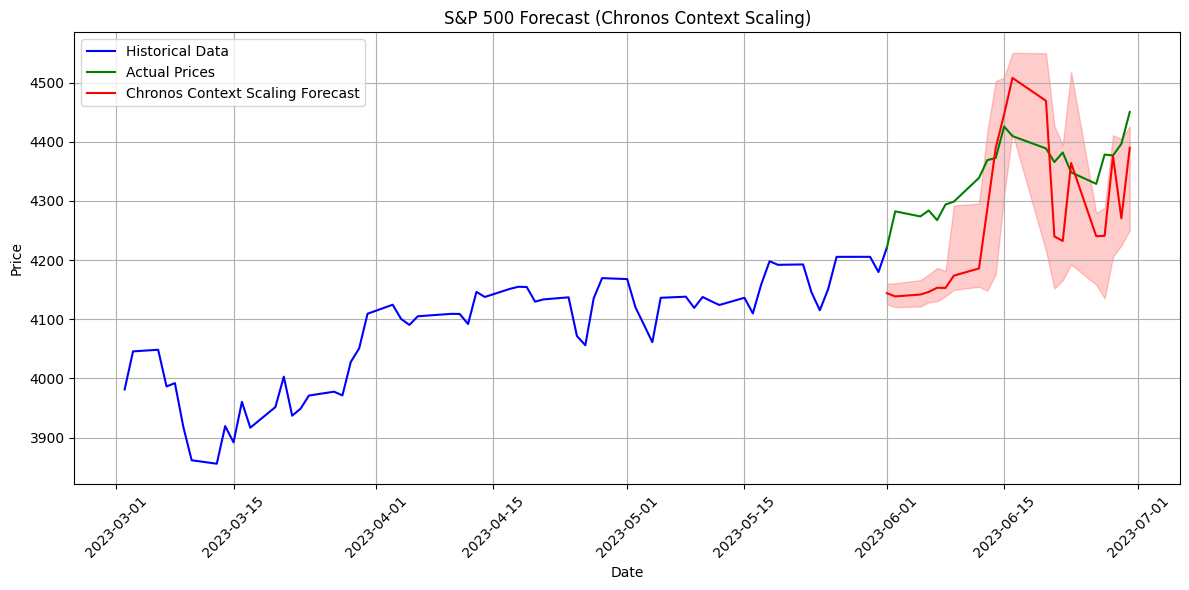

In [19]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler

from utils.metrics import calculate_metrics

# Updated Constants
CONTEXT_WINDOW = 63
FORECAST_STEPS = 1
CONFIDENCE_ALPHA = 0.2
TRAIN_RATIO = 0.8  # (No longer used, but kept for reference)
VAL_RATIO = 0.1    # (No longer used, but kept for reference)

# ======================
# Data Preparation (Date-Based)
# ======================
def prepare_data_by_date(data, test_date_str="2023-05-31"):
    """
    Splits 'data' so that everything before 'test_date_str' is considered
    train/val, and the test set starts on 'test_date_str'.
    Returns (train_end, val_end) indices.
    """
    # Ensure 'Date' is datetime, then sort
    data['Date'] = pd.to_datetime(data['Date'])
    data.sort_values('Date', inplace=True, ignore_index=True)
    
    # Find the first row where Date >= test_date_str
    test_date = pd.to_datetime(test_date_str)
    test_start_idx_candidates = data.index[data['Date'] >= test_date]
    if len(test_start_idx_candidates) == 0:
        raise ValueError(f"No data on or after {test_date_str}.")
    
    test_start_idx = test_start_idx_candidates[0]
    
    # We define both train_end and val_end to be test_start_idx
    # so the test set begins at test_start_idx
    train_end = test_start_idx
    val_end = test_start_idx
    
    return train_end, val_end

# ======================
# ARIMA Implementation (Fixed Scaling)
# ======================
class ARIMAPredictor:
    def __init__(self, train_data):
        self.scaler = StandardScaler()
        self.scaler.fit(train_data.reshape(-1, 1))  # Fit once on training data
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast"""
        try:
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            
            model = ARIMA(scaled_data, order=(1,1,1))
            model_fit = model.fit()
            forecast = model_fit.get_forecast(steps=1)
            
            median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
            ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
            return ci[0][0], median, ci[0][1]
        except Exception as e:
            raise e
    
    def expanding_window_forecast(self, full_data, start_idx):
        """Forecast with expanding window using fixed scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            # Ensure we have at least 2 samples for differencing
            if len(context_data) < 2:
                raise ValueError(f"Insufficient context data (need ≥2 samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            # Fix date alignment
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation (Fixed Scaling)
# ======================
class ChronosPredictor:
    def __init__(self, train_data):
        self.scaler = StandardScaler()
        self.scaler.fit(train_data.reshape(-1, 1))
        self.pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-large",
            # "./ft_chronos_sp500_closing_rk2/checkpoint-final/",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        try:
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            context = torch.tensor(scaled_data, dtype=torch.bfloat16)
            
            forecast = self.pipeline.predict(context, 1)
            forecast_np = forecast[0].cpu().numpy()
            
            forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
            return (
                np.quantile(forecast_original, 0.1).item(),
                np.quantile(forecast_original, 0.5).item(),
                np.quantile(forecast_original, 0.9).item()
            )
        except Exception as e:
            print(f"Chronos error: {str(e)}")
            last_val = self.scaler.inverse_transform([[context_data[-1]]])[0][0]
            return last_val*0.99, last_val, last_val*1.01

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < CONTEXT_WINDOW:
                raise ValueError(f"Need at least {CONTEXT_WINDOW} samples for context")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# ARIMA Implementation with Context Window Scaling
# ======================
class ARIMAPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast with context window scaling"""
        try:
            # Fit scaler on context window
            self.scaler.fit(context_data.reshape(-1, 1))
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            
            model = ARIMA(scaled_data, order=(1,1,1))
            model_fit = model.fit()
            forecast = model_fit.get_forecast(steps=1)
            
            median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
            ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
            return ci[0][0], median, ci[0][1]
        except Exception as e:
            raise e
    
    def expanding_window_forecast(self, full_data, start_idx):
        """Forecast with expanding window using context window scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < 2:
                raise ValueError(f"Insufficient context data (need ≥2 samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation with Context Window Scaling
# ======================
class ChronosPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pipeline = ChronosPipeline.from_pretrained(
            # "./ft_chronos_sp500_closing_rk2/checkpoint-final/",
            # "amazon/chronos-t5-large",
            "./fine_tuned_chronos_rk2_10000_sp500/checkpoint-final/",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        try:
            # Fit scaler on context window
            self.scaler.fit(context_data.reshape(-1, 1))
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            context = torch.tensor(scaled_data, dtype=torch.bfloat16)
            
            forecast = self.pipeline.predict(context, 64)
            forecast_np = forecast[0].cpu().numpy()
            
            forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
            return (
                np.quantile(forecast_original, 0.1).item(),
                np.quantile(forecast_original, 0.5).item(),
                np.quantile(forecast_original, 0.9).item()
            )
        except Exception as e:
            print(f"Chronos error: {str(e)}")
            last_val = context_data[-1]
            return last_val*0.99, last_val, last_val*1.01

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < CONTEXT_WINDOW:
                raise ValueError(f"Need at least {CONTEXT_WINDOW} samples for context")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Multiple Trials Comparison
# ======================
def run_multiple_trials_comparison(full_data, train_end, val_end, n_trials=10, test_start=None):
    """Run trials for both global and context scaling approaches."""
    
    # If user passes None, we default to val_end
    if test_start is None:
        test_start = val_end

    # Actual data over the forecast horizon
    actual = full_data['Close'].iloc[test_start : test_start + FORECAST_STEPS].values
    
    # 1) ARIMA Global Scaling
    train_data = full_data['Close'].iloc[:train_end].values
    arima_global = ARIMAPredictor(train_data)
    insample_data = full_data['Close'].iloc[test_start - CONTEXT_WINDOW : test_start].values
    arima_global_preds = arima_global.expanding_window_forecast(full_data, test_start)
    arima_global_metrics = calculate_metrics(actual, arima_global_preds['median'], insample=insample_data)
    
    # 2) ARIMA Context Window Scaling
    arima_context = ARIMAPredictorContextScale()
    arima_context_preds = arima_context.expanding_window_forecast(full_data, test_start)
    arima_context_metrics = calculate_metrics(actual, arima_context_preds['median'], insample=insample_data)
    
    # 3) Chronos Global Scaling
    chronos_global = ChronosPredictor(train_data)
    chronos_global_metrics_list = []
    chronos_global_preds = None
    
    # 4) Chronos Context Window Scaling
    chronos_context = ChronosPredictorContextScale()
    chronos_context_metrics_list = []
    chronos_context_preds = None
    
    for trial in range(n_trials):
        # Global scaling trial
        chronos_global_preds = chronos_global.sliding_window_forecast(full_data, test_start)
        chronos_global_metrics = calculate_metrics(actual, chronos_global_preds['median'], insample=insample_data)
        chronos_global_metrics_list.append(chronos_global_metrics)
        
        # Context window scaling trial
        chronos_context_preds = chronos_context.sliding_window_forecast(full_data, test_start)
        chronos_context_metrics = calculate_metrics(actual, chronos_context_preds['median'], insample=insample_data)
        chronos_context_metrics_list.append(chronos_context_metrics)
        
        print(f"\nTrial {trial}")
        print("Global scaling metrics:", chronos_global_metrics)
        print("Context scaling metrics:", chronos_context_metrics)
    
    # Average & std for Chronos Global
    chronos_global_avg = {
        metric: np.mean([m[metric] for m in chronos_global_metrics_list]) 
        for metric in chronos_global_metrics_list[0]
    }
    chronos_global_std = {
        metric: np.std([m[metric] for m in chronos_global_metrics_list]) 
        for metric in chronos_global_metrics_list[0]
    }
    
    # Average & std for Chronos Context
    chronos_context_avg = {
        metric: np.mean([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    chronos_context_std = {
        metric: np.std([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    
    return (
        # arima_global_metrics,
        arima_context_metrics, 
        # chronos_global_avg,
        # chronos_global_std,
        chronos_context_avg,
        chronos_context_std,
        # arima_global_preds,
        arima_context_preds,
        # chronos_global_preds,
        chronos_context_preds
    )

# ======================
# Plotting
# ======================
def plot_individual_forecast(data, start_idx, forecasts, model_name):
    """Fixed plotting function with proper index alignment"""
    plt.figure(figsize=(12, 6))
    
    # Historical data (3 months before forecast start)
    historical_start = max(0, start_idx - 63)
    historical = data.iloc[historical_start:start_idx + 1]
    plt.plot(historical['Date'], historical['Close'], 'b-', label='Historical Data')
    
    # Actual values with CORRECTED indices
    actual_dates = data['Date'].iloc[start_idx:start_idx+FORECAST_STEPS]
    actual_values = data['Close'].iloc[start_idx:start_idx+FORECAST_STEPS]
    plt.plot(actual_dates, actual_values, 'g-', label='Actual Prices')
    
    # Forecasts with alignment validation
    forecast_dates = forecasts['dates']
    if len(forecast_dates) != FORECAST_STEPS:
        raise ValueError(f"Expected {FORECAST_STEPS} forecast dates, got {len(forecast_dates)}")
    
    # Updated IF check to cover both ARIMA naming conventions:
    if model_name in ["ARIMA Global Scaling", "ARIMA Context Scaling"]:
        # ARIMA -> No confidence fill
        plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
    else:
        # Chronos -> Plot fill-between for confidence
        plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
        plt.fill_between(forecast_dates, forecasts['low'], forecasts['high'], color='red', alpha=0.2)
    
    plt.title(f'S&P 500 Forecast ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# ======================
# Main Entry
# ======================
def main():
    # Suppose 'snp500_daily' is already loaded somewhere above or imported
    # as a DataFrame with columns 'Date' and 'Close'.
    
    # 1) Use date-based preparation. Modify the second argument to any date you like.
    test_date_str = "2023-06-01"  # Change this if you want a different test start
    train_end, val_end = prepare_data_by_date(snp500_daily, test_date_str)
    
    # 2) Pass these indices to your multiple-trials function
    results = run_multiple_trials_comparison(snp500_daily, train_end, val_end, n_trials=1, test_start=None)
    
    (arima_context_metrics, 
     chronos_context_avg, chronos_context_std,
     arima_context_preds,
     chronos_context_preds) = results
    
    # # Print results
    # print("\nARIMA Global Scaling Metrics:")
    # for metric, value in arima_global_metrics.items():
    #     print(f"{metric}: {value:.4f}")
    
    print("\nARIMA Context Window Scaling Metrics:")
    for metric, value in arima_context_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # print("\nChronos Global Scaling Metrics (Average ± Std):")
    # for metric in chronos_global_avg:
    #     print(f"{metric}: {chronos_global_avg[metric]:.4f} ± {chronos_global_std[metric]:.4f}")
    
    print("\nChronos Context Window Scaling Metrics (Average ± Std):")
    for metric in chronos_context_avg:
        print(f"{metric}: {chronos_context_avg[metric]:.4f} ± {chronos_context_std[metric]:.4f}")
    
    # Plot results
    test_start = val_end  # By definition in run_multiple_trials_comparison
    # plot_individual_forecast(snp500_daily, test_start, arima_global_preds, "ARIMA Global Scaling")
    plot_individual_forecast(snp500_daily, test_start, arima_context_preds, "ARIMA Context Scaling")
    # plot_individual_forecast(snp500_daily, test_start, chronos_global_preds, "Chronos Global Scaling")
    plot_individual_forecast(snp500_daily, test_start, chronos_context_preds, "Chronos Context Scaling")

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler

from utils.metrics import calculate_metrics

# Updated Constants
CONTEXT_WINDOW = 63
FORECAST_STEPS = 10
CONFIDENCE_ALPHA = 0.2
TRAIN_RATIO = 0.8  # (No longer used, but kept for reference)
VAL_RATIO = 0.1    # (No longer used, but kept for reference)

# ======================
# ARIMA Implementation with Context Window Scaling
# ======================
class ARIMAPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast with context window scaling"""
        try:
            # Fit scaler on context window
            self.scaler.fit(context_data.reshape(-1, 1))
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            
            model = ARIMA(scaled_data, order=(1,1,1))
            model_fit = model.fit()
            forecast = model_fit.get_forecast(steps=1)
            
            median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
            ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
            return ci[0][0], median, ci[0][1]
        except Exception as e:
            raise e
    
    def expanding_window_forecast(self, full_data, start_idx):
        """Forecast with expanding window using context window scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = current_idx - CONTEXT_WINDOW
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < 2:
                raise ValueError(f"Insufficient context data (need ≥2 samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation with Context Window Scaling
# ======================
class ChronosPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pipeline = ChronosPipeline.from_pretrained(
            # "./ft_chronos_sp500_closing_rk2/checkpoint-final/",
            # "amazon/chronos-t5-large",
            "./fine_tuned_chronos_rk2_10000_sp500/checkpoint-final/",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        try:
            # Fit scaler on context window
            self.scaler.fit(context_data.reshape(-1, 1))
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            context = torch.tensor(scaled_data, dtype=torch.bfloat16)
            
            forecast = self.pipeline.predict(context, 1)
            forecast_np = forecast[0].cpu().numpy()
            
            forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
            return (
                np.quantile(forecast_original, 0.1).item(),
                np.quantile(forecast_original, 0.5).item(),
                np.quantile(forecast_original, 0.9).item()
            )
        except Exception as e:
            print(f"Chronos error: {str(e)}")
            last_val = context_data[-1]
            return last_val*0.99, last_val, last_val*1.01

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < CONTEXT_WINDOW:
                raise ValueError(f"Need at least {CONTEXT_WINDOW} samples for context")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Multiple Trials Comparison
# ======================
def run_multiple_trials_comparison(full_data, n_trials=10, test_start=None):
    """Run trials for both global and context scaling approaches."""
    

    # Actual data over the forecast horizon
    actual = full_data['Close'].iloc[test_start : test_start + FORECAST_STEPS].values
    
    insample_data = full_data['Close'].iloc[test_start - CONTEXT_WINDOW : test_start].values
    
    # 2) ARIMA Context Window Scaling
    arima_context = ARIMAPredictorContextScale()
    arima_context_preds = arima_context.expanding_window_forecast(full_data, test_start)
    arima_context_metrics = calculate_metrics(actual, arima_context_preds['median'], insample=insample_data)
    
    # 4) Chronos Context Window Scaling
    chronos_context = ChronosPredictorContextScale()
    chronos_context_metrics_list = []
    chronos_context_preds = None
    
    for trial in range(n_trials):
        
        # Context window scaling trial
        chronos_context_preds = chronos_context.sliding_window_forecast(full_data, test_start)
        chronos_context_metrics = calculate_metrics(actual, chronos_context_preds['median'], insample=insample_data)
        chronos_context_metrics_list.append(chronos_context_metrics)
        
        print(f"\nTrial {trial}")
        print("Context scaling metrics:", chronos_context_metrics)
    
    # Average & std for Chronos Context
    chronos_context_avg = {
        metric: np.mean([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    chronos_context_std = {
        metric: np.std([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    
    return (
        arima_context_metrics, 
        chronos_context_avg,
        chronos_context_std,
        arima_context_preds,
        chronos_context_preds
    )

# ======================
# Plotting
# ======================
def plot_individual_forecast(data, start_idx, forecasts, model_name):
    """Fixed plotting function with proper index alignment"""
    plt.figure(figsize=(12, 6))
    
    # Historical data (3 months before forecast start)
    historical_start = max(0, start_idx - 63)
    historical = data.iloc[historical_start:start_idx + 1]
    plt.plot(historical['Date'], historical['Close'], 'b-', label='Historical Data')
    
    # Actual values with CORRECTED indices
    actual_dates = data['Date'].iloc[start_idx:start_idx+FORECAST_STEPS]
    actual_values = data['Close'].iloc[start_idx:start_idx+FORECAST_STEPS]
    plt.plot(actual_dates, actual_values, 'g-', label='Actual Prices')
    
    # Forecasts with alignment validation
    forecast_dates = forecasts['dates']
    if len(forecast_dates) != FORECAST_STEPS:
        raise ValueError(f"Expected {FORECAST_STEPS} forecast dates, got {len(forecast_dates)}")
    
    # Updated IF check to cover both ARIMA naming conventions:
    if model_name in ["ARIMA Global Scaling", "ARIMA Context Scaling"]:
        # ARIMA -> No confidence fill
        plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
    else:
        # Chronos -> Plot fill-between for confidence
        plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
        plt.fill_between(forecast_dates, forecasts['low'], forecasts['high'], color='red', alpha=0.2)
    
    plt.title(f'S&P 500 Forecast ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# ======================
# Main Entry
# ======================
def main():
    # Suppose 'snp500_daily' is already loaded somewhere above or imported
    # as a DataFrame with columns 'Date' and 'Close'.
    
    # 1) Use date-based preparation. Modify the second argument to any date you like.
    test_date_str = "2023-06-01"  # Change this if you want a different test start
    
    # 2) Pass these indices to your multiple-trials function
    results = run_multiple_trials_comparison(snp500_daily, train_end, val_end, n_trials=10, test_start=None)
    
    (arima_context_metrics, 
     chronos_context_avg, chronos_context_std,
     arima_context_preds,
     chronos_context_preds) = results
    
    print("\nARIMA Context Window Scaling Metrics:")
    for metric, value in arima_context_metrics.items():
        print(f"{metric}: {value:.4f}")

    
    print("\nChronos Context Window Scaling Metrics (Average ± Std):")
    for metric in chronos_context_avg:
        print(f"{metric}: {chronos_context_avg[metric]:.4f} ± {chronos_context_std[metric]:.4f}")
    
    # Plot results
    test_start = val_end  
    plot_individual_forecast(snp500_daily, test_start, arima_context_preds, "ARIMA Context Scaling")
    plot_individual_forecast(snp500_daily, test_start, chronos_context_preds, "Chronos Context Scaling")

if __name__ == "__main__":
    main()


# HEY

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodel


Trial 1/10
Context scaling metrics: {'MAE': 31.24062965029762, 'MSE': 1642.7398634013675, 'RMSE': 40.53072739788132, 'Z-NormalizedMAE': 0.5370966213588136, 'Z-NormalizedMSE': 0.4855501359092628, 'Z-NormalizedRMSE': 0.696814276482093, 'MAPE': 0.7128602861304872, 'SMAPE': 0.7099393305076444, 'MASE': 1.5594830266804225, 'DirectionalAccuracy': nan}

Trial 2/10
Context scaling metrics: {'MAE': 31.675351097470237, 'MSE': 1646.1520091834523, 'RMSE': 40.57279888279156, 'Z-NormalizedMAE': 0.5445704598544601, 'Z-NormalizedMSE': 0.48655867529224406, 'Z-NormalizedRMSE': 0.6975375798422935, 'MAPE': 0.7223390924574425, 'SMAPE': 0.7193941160579634, 'MASE': 1.5811836366165346, 'DirectionalAccuracy': nan}

Trial 3/10
Context scaling metrics: {'MAE': 31.328973679315474, 'MSE': 1602.711682050001, 'RMSE': 40.03388167602538, 'Z-NormalizedMAE': 0.5386154537265941, 'Z-NormalizedMSE': 0.4737188719773618, 'Z-NormalizedRMSE': 0.688272382111444, 'MAPE': 0.7145830757832289, 'SMAPE': 0.7118555336428682, 'MASE': 1

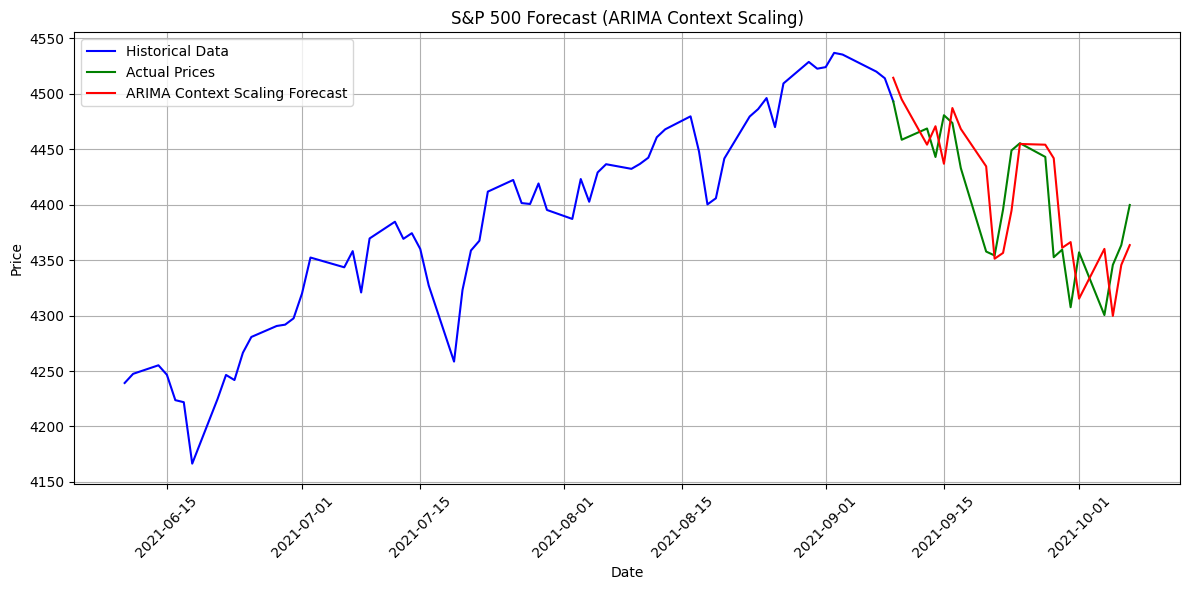

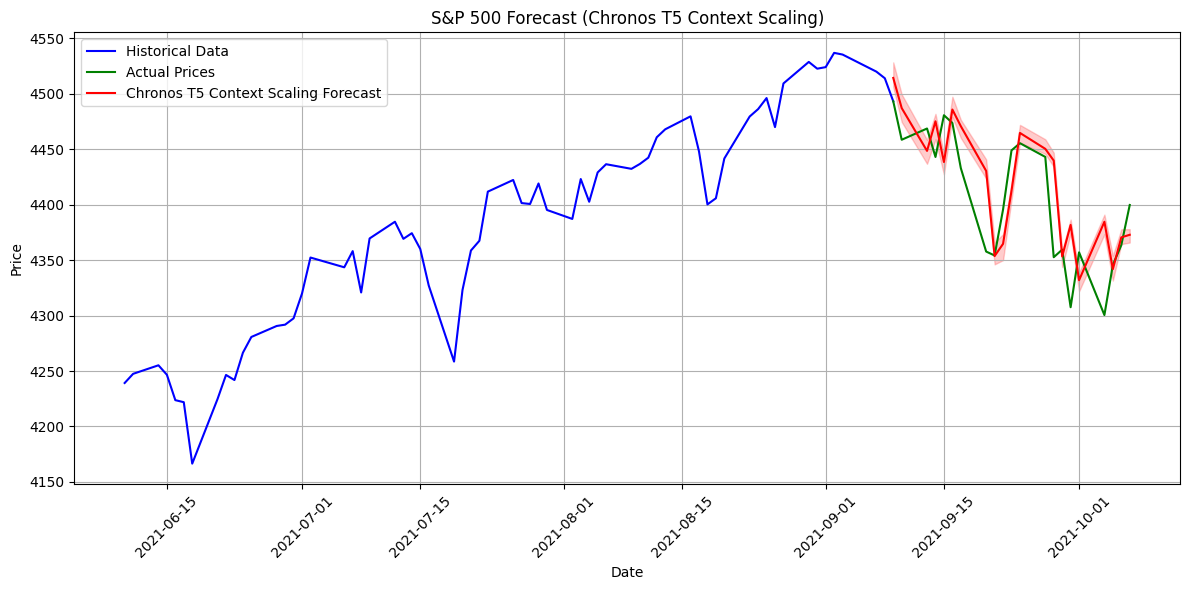

In [5]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler

from utils.metrics import calculate_metrics
from data.snp500 import snp500_daily

# Updated Constants
CONTEXT_WINDOW = 63
FORECAST_STEPS = 21
CONFIDENCE_ALPHA = 0.2
MIN_CONTEXT_SIZE = 10  # Minimum context size required for all models

# ======================
# ARIMA Implementation with Context Window Scaling
# ======================
class ARIMAPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast with context window scaling"""
        # Fit scaler on context window
        self.scaler.fit(context_data.reshape(-1, 1))
        scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        
        model = ARIMA(scaled_data, order=(1,1,1))
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=1)
        
        median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
        ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
        return ci[0][0], median, ci[0][1]

    
    def sliding_window_forecast(self, full_data, start_idx):
        """Forecast with sliding window using context window scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < MIN_CONTEXT_SIZE:
                raise ValueError(f"Insufficient context data (need ≥{MIN_CONTEXT_SIZE} samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation with Context Window Scaling
# ======================
class ChronosPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pipeline = ChronosPipeline.from_pretrained(
            # Update the path to your fine-tuned model
            # "./fine_tuned_chronos_4/checkpoint-final/",
            "amazon/chronos-t5-large",
            device_map="mps",  # Change to "cuda" or "cpu" based on your hardware
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):

        # Fit scaler on context window
        self.scaler.fit(context_data.reshape(-1, 1))
        scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context = torch.tensor(scaled_data, dtype=torch.bfloat16)
        
        forecast = self.pipeline.predict(context, 1)
        forecast_np = forecast[0].cpu().numpy()
        
        forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
        return (
            np.quantile(forecast_original, 0.1).item(),
            np.quantile(forecast_original, 0.5).item(),
            np.quantile(forecast_original, 0.9).item()
        )

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < MIN_CONTEXT_SIZE:
                raise ValueError(f"Insufficient context data (need ≥{MIN_CONTEXT_SIZE} samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Multiple Trials Comparison
# ======================
def run_multiple_trials_comparison(full_data, n_trials=10, test_start=None):
    """Run trials for both models with consistent context window scaling approach."""
    
    # Ensure we have enough historical data for context
    if test_start < CONTEXT_WINDOW + MIN_CONTEXT_SIZE:
        raise ValueError(f"Test start index {test_start} too small, need at least {CONTEXT_WINDOW + MIN_CONTEXT_SIZE} for context")
    
    # Actual data over the forecast horizon
    actual = full_data['Close'].iloc[test_start : test_start + FORECAST_STEPS].values
    
    # In-sample data (used for metric calculation)
    insample_data = full_data['Close'].iloc[test_start - CONTEXT_WINDOW : test_start].values
    
    # ARIMA Context Window Scaling
    arima_context = ARIMAPredictorContextScale()
    arima_context_preds = arima_context.sliding_window_forecast(full_data, test_start)
    arima_context_metrics = calculate_metrics(actual, arima_context_preds['median'], insample=insample_data)
    
    # Chronos Context Window Scaling
    chronos_context = ChronosPredictorContextScale()
    chronos_context_metrics_list = []
    chronos_context_preds = None
    
    for trial in range(n_trials):
        # Context window scaling trial
        chronos_context_preds = chronos_context.sliding_window_forecast(full_data, test_start)
        
        # Ensure the predictions are properly aligned with actual values
        if len(chronos_context_preds['median']) != len(actual):
            print(f"Warning: Chronos prediction length ({len(chronos_context_preds['median'])}) doesn't match actual data length ({len(actual)})")
        
        chronos_context_metrics = calculate_metrics(
            actual[:len(chronos_context_preds['median'])], 
            chronos_context_preds['median'][:len(actual)], 
            insample=insample_data
        )
        chronos_context_metrics_list.append(chronos_context_metrics)
        
        print(f"\nTrial {trial+1}/{n_trials}")
        print("Context scaling metrics:", chronos_context_metrics)
    
    # Average & std for Chronos Context
    chronos_context_avg = {
        metric: np.mean([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    chronos_context_std = {
        metric: np.std([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    
    return (
        arima_context_metrics, 
        chronos_context_avg,
        chronos_context_std,
        arima_context_preds,
        chronos_context_preds
    )

# ======================
# Plotting
# ======================
def plot_individual_forecast(data, start_idx, forecasts, model_name, actual_data=None):
    """Plotting function with proper index alignment and verification."""
    plt.figure(figsize=(12, 6))
    
    # Historical data (context window before forecast start)
    historical_start = max(0, start_idx - CONTEXT_WINDOW)
    historical = data.iloc[historical_start:start_idx+1]
    plt.plot(historical['Date'], historical['Close'], 'b-', label='Historical Data')
    
    # Actual values with verified indices
    actual_dates = data['Date'].iloc[start_idx:start_idx+FORECAST_STEPS]
    actual_values = data['Close'].iloc[start_idx:start_idx+FORECAST_STEPS]
    
    if actual_data is not None:
        # Use provided actual data if available
        if len(actual_data) != len(actual_dates):
            print(f"Warning: Provided actual data length ({len(actual_data)}) doesn't match expected ({len(actual_dates)})")
        
        plt.plot(actual_dates[:len(actual_data)], actual_data, 'g-', label='Actual Prices')
    else:
        plt.plot(actual_dates, actual_values, 'g-', label='Actual Prices')
    
    # Forecasts with alignment validation
    forecast_dates = forecasts['dates']
    if len(forecast_dates) != len(actual_dates):
        print(f"Warning: Forecast length ({len(forecast_dates)}) doesn't match actual data length ({len(actual_dates)})")
        # Use the minimum length for plotting
        plot_length = min(len(forecast_dates), len(actual_dates))
        forecast_dates = forecast_dates[:plot_length]
        actual_dates = actual_dates[:plot_length]

    # Updated IF check to cover both ARIMA naming conventions:
    if model_name in ["ARIMA Global Scaling", "ARIMA Context Scaling"]:
        # ARIMA -> No confidence fill
        plt.plot(forecast_dates, forecasts['median'][:len(forecast_dates)], 'r-', label=f'{model_name} Forecast')
    else:
        # Chronos -> Plot fill-between for confidence
        plt.plot(forecast_dates, forecasts['median'][:len(forecast_dates)], 'r-', label=f'{model_name} Forecast')
        plt.fill_between(
            forecast_dates, 
            forecasts['low'][:len(forecast_dates)], 
            forecasts['high'][:len(forecast_dates)], 
            color='red', 
            alpha=0.2
        )
    
    plt.title(f'S&P 500 Forecast ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ======================
# Main Entry
# ======================
def main():
    from data.snp500 import snp500_daily
    snp500_daily = snp500_daily
    
    # Select test start date
    test_date_str = "2021-09-08"
    try:
        # Find the index where date matches or closest date before
        test_date = pd.Timestamp(test_date_str)
        date_indices = snp500_daily[snp500_daily['Date'] <= test_date].index
        if len(date_indices) == 0:
            raise ValueError(f"No dates before {test_date_str} found in the dataset")
        test_start = date_indices[-1]
    except Exception as e:
        print(f"Error finding test start date: {str(e)}")
        # Fall back to using 80% of data as training
        test_start = int(len(snp500_daily) * 0.8)
        print(f"Falling back to using index {test_start} as test start")
    
    # Run comparison
    results = run_multiple_trials_comparison(
        snp500_daily, 
        n_trials=10, 
        test_start=test_start
    )
    
    (arima_context_metrics, 
        chronos_context_avg, chronos_context_std,
        arima_context_preds,
        chronos_context_preds) = results
    
    print("\nARIMA Context Window Scaling Metrics:")
    for metric, value in arima_context_metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nChronos Context Window Scaling Metrics (Average ± Std):")
    for metric in chronos_context_avg:
        print(f"{metric}: {chronos_context_avg[metric]:.4f} ± {chronos_context_std[metric]:.4f}")
    
    # Plot results
    plot_individual_forecast(snp500_daily, test_start, arima_context_preds, "ARIMA Context Scaling")
    plot_individual_forecast(snp500_daily, test_start, chronos_context_preds, "Chronos T5 Context Scaling")
    

if __name__ == "__main__":
    main()

[*********************100%***********************]  1 of 1 completed


tensor([[[0.8497],
         [0.7443],
         [0.9366],
         [0.7691],
         [1.0296],
         [0.9056],
         [0.9118],
         [0.8063],
         [0.8932],
         [0.9428],
         [0.7567],
         [0.8435],
         [0.8187],
         [0.8559],
         [1.0358],
         [0.8870],
         [0.8684],
         [0.7567],
         [0.8125],
         [0.9738]]])
[[[0.8497463 ]
  [0.7443033 ]
  [0.9365817 ]
  [0.7691134 ]
  [1.0296196 ]
  [0.9055691 ]
  [0.9117716 ]
  [0.80632854]
  [0.89316404]
  [0.9427842 ]
  [0.7567084 ]
  [0.84354377]
  [0.81873363]
  [0.8559488 ]
  [1.0358222 ]
  [0.8869614 ]
  [0.86835384]
  [0.7567084 ]
  [0.8125311 ]
  [0.9737968 ]]]
tensor([[[1.3349],
         [1.3900],
         [1.4084],
         [1.5247],
         [1.5002],
         [1.4880],
         [1.3349],
         [1.3900],
         [1.2798],
         [1.2614],
         [1.3471],
         [1.5492],
         [1.3288],
         [1.4635],
         [1.5063],
         [1.3288],
         [1.

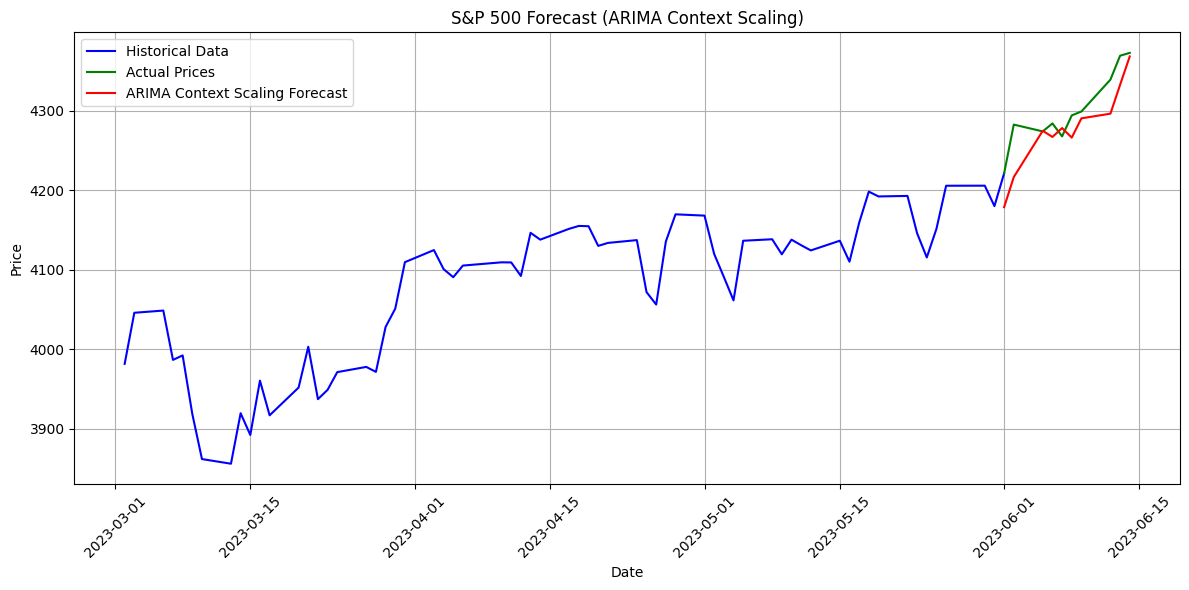

[Timestamp('2023-06-01 00:00:00'), Timestamp('2023-06-02 00:00:00'), Timestamp('2023-06-05 00:00:00'), Timestamp('2023-06-06 00:00:00'), Timestamp('2023-06-07 00:00:00'), Timestamp('2023-06-08 00:00:00'), Timestamp('2023-06-09 00:00:00'), Timestamp('2023-06-12 00:00:00'), Timestamp('2023-06-13 00:00:00'), Timestamp('2023-06-14 00:00:00')]


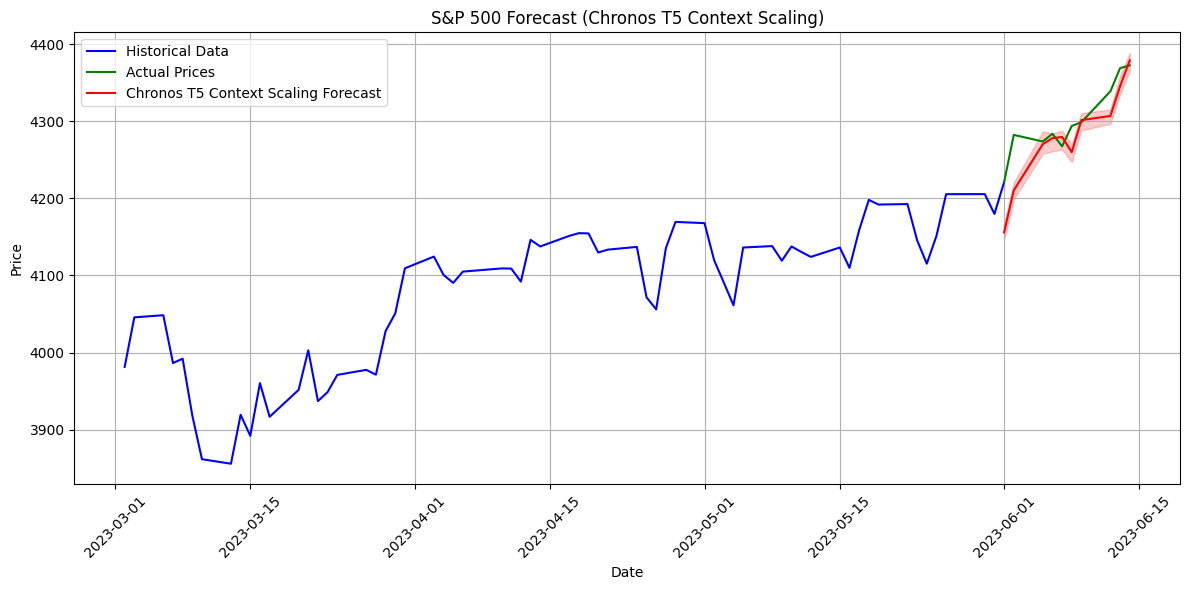

In [118]:
import yfinance as yf
import pandas as pd

nvidia_data = yf.download("^GSPC", start="2000-01-01", end="2025-02-10")
nvidia_data.reset_index(inplace=True)
nvidia_data['Date'] = pd.to_datetime(nvidia_data['Date'])
nvidia_data

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler

from utils.metrics import calculate_metrics
from data.snp500 import snp500_daily

# Updated Constants
CONTEXT_WINDOW = 63
FORECAST_STEPS = 10
CONFIDENCE_ALPHA = 0.2
MIN_CONTEXT_SIZE = 10  # Minimum context size required for all models

# ======================
# ARIMA Implementation with Context Window Scaling
# ======================
class ARIMAPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast with context window scaling"""
        # Fit scaler on context window
        self.scaler.fit(context_data.reshape(-1, 1))
        scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        
        model = ARIMA(scaled_data, order=(1,1,1))
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=1)
        
        median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
        ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
        return ci[0][0], median, ci[0][1]

    
    def sliding_window_forecast(self, full_data, start_idx):
        """Forecast with sliding window using context window scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < MIN_CONTEXT_SIZE:
                raise ValueError(f"Insufficient context data (need ≥{MIN_CONTEXT_SIZE} samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation with Context Window Scaling
# ======================
class ChronosPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pipeline = ChronosPipeline.from_pretrained(
            # Update the path to your fine-tuned model
            "amazon/chronos-t5-tiny",
            # "./ft_chronos_tiny_rk2_3000/checkpoint-3000/",
            device_map="mps",  # Change to "cuda" or "cpu" based on your hardware
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):

        # Fit scaler on context window
        self.scaler.fit(context_data.reshape(-1, 1))
        scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context = torch.tensor(scaled_data, dtype=torch.bfloat16)
        
        forecast = self.pipeline.predict(context, 1)
        print(forecast)
        forecast_np = forecast.cpu().numpy()
        print(forecast_np)
        
        forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
        return (
            np.quantile(forecast_original, 0.1).item(),
            np.quantile(forecast_original, 0.5).item(),
            np.quantile(forecast_original, 0.9).item()
        )

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < MIN_CONTEXT_SIZE:
                raise ValueError(f"Insufficient context data (need ≥{MIN_CONTEXT_SIZE} samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Multiple Trials Comparison
# ======================
def run_multiple_trials_comparison(full_data, n_trials=10, test_start=None):
    """Run trials for both models with consistent context window scaling approach."""
    
    # Ensure we have enough historical data for context
    if test_start < CONTEXT_WINDOW + MIN_CONTEXT_SIZE:
        raise ValueError(f"Test start index {test_start} too small, need at least {CONTEXT_WINDOW + MIN_CONTEXT_SIZE} for context")
    
    # Actual data over the forecast horizon
    actual = full_data['Close'].iloc[test_start : test_start + FORECAST_STEPS].values

    # Get the last historical point for directional accuracy calculation
    historical_last_point = full_data['Close'].iloc[test_start - 1] if test_start > 0 else None

    # In-sample data (used for metric calculation)
    insample_data = full_data['Close'].iloc[test_start - CONTEXT_WINDOW : test_start].values
    
    # ARIMA Context Window Scaling
    arima_context = ARIMAPredictorContextScale()
    arima_context_preds = arima_context.sliding_window_forecast(full_data, test_start)
    
    # Calculate metrics including directional accuracy with historical point
    arima_metrics = calculate_metrics(
        actual, 
        arima_context_preds['median'], 
        insample=insample_data,
        historical_last_point=historical_last_point  # Pass historical point
    )
    
    # Chronos Context Window Scaling
    chronos_context = ChronosPredictorContextScale()
    chronos_context_metrics_list = []
    chronos_context_preds = None
    
    for trial in range(n_trials):
        # Context window scaling trial
        chronos_context_preds = chronos_context.sliding_window_forecast(full_data, test_start)
        print(chronos_context_preds)
        
        # Ensure the predictions are properly aligned with actual values
        if len(chronos_context_preds['median']) != len(actual):
            print(f"Warning: Chronos prediction length ({len(chronos_context_preds['median'])}) doesn't match actual data length ({len(actual)})")
            # Use the minimum length for evaluation
            min_length = min(len(chronos_context_preds['median']), len(actual))
            chronos_actual = actual[:min_length]
            chronos_preds = chronos_context_preds['median'][:min_length]
        else:
            chronos_actual = actual
            chronos_preds = chronos_context_preds['median']
        
        # Calculate metrics with historical point for better directional accuracy
        chronos_metrics = calculate_metrics(
            chronos_actual, 
            chronos_preds, 
            insample=insample_data,
            historical_last_point=historical_last_point,
            directional_accuracy=False,
        )
        print(chronos_metrics)
        chronos_context_metrics_list.append(chronos_metrics)
        
        print(f"\nTrial {trial+1}/{n_trials}")
        print("Context scaling metrics:", chronos_metrics)
    print(chronos_context_metrics_list)
    # Average & std for Chronos Context
    chronos_context_avg = {
        metric: np.mean([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    chronos_context_std = {
        metric: np.std([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    
    return (
        arima_metrics, 
        chronos_context_avg,
        chronos_context_std,
        arima_context_preds,
        chronos_context_preds
    )

# ======================
# Plotting
# ======================
def plot_individual_forecast(data, start_idx, forecasts, model_name, actual_data=None):
    """Plotting function with proper index alignment and verification."""
    plt.figure(figsize=(12, 6))
    
    # Historical data (context window before forecast start)
    historical_start = max(0, start_idx - 63)
    historical = data.iloc[historical_start:start_idx+1]
    plt.plot(historical['Date'], historical['Close'], 'b-', label='Historical Data')
    
    # Actual values with verified indices
    actual_dates = data['Date'].iloc[start_idx:start_idx+FORECAST_STEPS]
    actual_values = data['Close'].iloc[start_idx:start_idx+FORECAST_STEPS]
    
    if actual_data is not None:
        # Use provided actual data if available
        if len(actual_data) != len(actual_dates):
            print(f"Warning: Provided actual data length ({len(actual_data)}) doesn't match expected ({len(actual_dates)})")
        
        plt.plot(actual_dates[:len(actual_data)], actual_data, 'g-', label='Actual Prices')
    else:
        plt.plot(actual_dates, actual_values, 'g-', label='Actual Prices')
    
    # Forecasts with alignment validation
    forecast_dates = forecasts['dates']
    print(forecast_dates)
    if len(forecast_dates) != len(actual_dates):
        print(f"Warning: Forecast length ({len(forecast_dates)}) doesn't match actual data length ({len(actual_dates)})")
        # Use the minimum length for plotting
        plot_length = min(len(forecast_dates), len(actual_dates))
        forecast_dates = forecast_dates[:plot_length]
        actual_dates = actual_dates[:plot_length]

    # Updated IF check to cover both ARIMA naming conventions:
    if model_name in ["ARIMA Global Scaling", "ARIMA Context Scaling"]:
        # ARIMA -> No confidence fill
        plt.plot(forecast_dates, forecasts['median'][:len(forecast_dates)], 'r-', label=f'{model_name} Forecast')
    else:
        # Chronos -> Plot fill-between for confidence
        plt.plot(forecast_dates, forecasts['median'][:len(forecast_dates)], 'r-', label=f'{model_name} Forecast')
        plt.fill_between(
            forecast_dates, 
            forecasts['low'][:len(forecast_dates)], 
            forecasts['high'][:len(forecast_dates)], 
            color='red', 
            alpha=0.2
        )
    
    plt.title(f'S&P 500 Forecast ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ======================
# Main Entry
# ======================
def main():
    from data.snp500 import snp500_daily
    snp500_daily = nvidia_data
    
    # Select test start date
    test_date_str = "2023-06-01"
    # Find the index where date matches or closest date before
    test_date = pd.Timestamp(test_date_str)
    date_indices = snp500_daily[snp500_daily['Date'] <= test_date].index
    if len(date_indices) == 0:
        raise ValueError(f"No dates before {test_date_str} found in the dataset")
    test_start = date_indices[-1]
    
    # Run comparison
    results = run_multiple_trials_comparison(
        snp500_daily, 
        n_trials=1, 
        test_start=test_start
    )
    
    (arima_context_metrics, 
        chronos_context_avg, chronos_context_std,
        arima_context_preds,
        chronos_context_preds) = results
    
    print("\nARIMA Context Window Scaling Metrics:")
    for metric, value in arima_context_metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nChronos Context Window Scaling Metrics (Average ± Std):")
    for metric in chronos_context_avg:
        print(f"{metric}: {chronos_context_avg[metric]:.4f} ± {chronos_context_std[metric]:.4f}")
    
    # Plot results
    plot_individual_forecast(snp500_daily, test_start, arima_context_preds, "ARIMA Context Scaling")
    plot_individual_forecast(snp500_daily, test_start, chronos_context_preds, "Chronos T5 Context Scaling")
    

if __name__ == "__main__":
    main()

[*********************100%***********************]  1 of 1 completed
/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_91502/2270924416.py:132: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  historical_last_point = float(full_data['Close'].iloc[test_start - 1]) if test_start > 0 else None
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary s


----- DATA FOR MANUAL VALIDATION -----
Historical last point: 37.812923431396484
Actual values: [[39.7478447 ]
 [39.30509186]
 [39.14918518]
 [38.63246536]
 [37.45799255]
 [38.49253082]
 [38.75240707]
 [39.46408844]
 [41.00338745]
 [42.97749329]
 [42.63365173]
 [42.67263031]
 [43.78812408]
 [43.02547073]
 [43.00547791]
 [42.18984985]
 [40.61356735]
 [41.85700226]
 [41.09834671]
 [40.80347824]
 [42.2828064 ]]


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ARIMA predictions: [37.62152061052473, 39.79961438175994, 39.300791064917085, 39.14502601254718, 38.615260489111705, 37.4140395466047, 38.51037329088326, 38.76129564858171, 39.48104388647671, 41.05822024503036, 43.121372162050676, 42.62940824915244, 42.6742026675717, 43.846848190050224, 43.00033135985666, 43.00082609230989, 42.153012493277295, 40.610296138530195, 41.89301863963239, 41.083695550059154, 40.79325938443767]
Forecast dates: ['2023-06-01', '2023-06-02', '2023-06-05', '2023-06-06', '2023-06-07', '2023-06-08', '2023-06-09', '2023-06-12', '2023-06-13', '2023-06-14', '2023-06-15', '2023-06-16', '2023-06-20', '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-26', '2023-06-27', '2023-06-28', '2023-06-29', '2023-06-30']

----- DIRECTIONAL ANALYSIS -----
Date | Actual | Direction | Predicted | Direction | Match?
2023-06-01 | 39.75 | UP | 37.62 | DOWN | NO
2023-06-02 | 39.31 | DOWN | 39.80 | UP | NO
2023-06-05 | 39.15 | DOWN | 39.30 | DOWN | YES
2023-06-06 | 38.63 | DOWN | 39.15 | D

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Trial 1/10
Context scaling metrics: {'MAE': 0.9866951533726284, 'MSE': 1.5147703014128118, 'RMSE': 1.230760050299331, 'Z-NormalizedMAE': 0.2833262948696383, 'Z-NormalizedMSE': 0.12489773321556374, 'Z-NormalizedRMSE': 0.35340873392654537, 'MAPE': 2.411606513573658, 'SMAPE': 2.4409883850960976, 'MASE': nan, 'DirectionalAccuracy': 52.63157894736842}


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Trial 2/10
Context scaling metrics: {'MAE': 1.059864770798456, 'MSE': 1.6450579225219415, 'RMSE': 1.2825981141892973, 'Z-NormalizedMAE': 0.30433671184739314, 'Z-NormalizedMSE': 0.13564037091277845, 'Z-NormalizedRMSE': 0.368293864886151, 'MAPE': 2.5885178393565447, 'SMAPE': 2.614733761146756, 'MASE': nan, 'DirectionalAccuracy': 47.368421052631575}


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Trial 3/10
Context scaling metrics: {'MAE': 0.985862550281343, 'MSE': 1.5102368782768498, 'RMSE': 1.2289169533686357, 'Z-NormalizedMAE': 0.2830872156077765, 'Z-NormalizedMSE': 0.1245239377477885, 'Z-NormalizedRMSE': 0.3528794946547454, 'MAPE': 2.410005183436213, 'SMAPE': 2.4375391508138127, 'MASE': nan, 'DirectionalAccuracy': 52.63157894736842}


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Trial 4/10
Context scaling metrics: {'MAE': 1.0165928431919642, 'MSE': 1.5712608023216792, 'RMSE': 1.2534994225454112, 'Z-NormalizedMAE': 0.29191131898039835, 'Z-NormalizedMSE': 0.12955555856713596, 'Z-NormalizedRMSE': 0.35993827049528365, 'MAPE': 2.4863433329515794, 'SMAPE': 2.515210951666872, 'MASE': nan, 'DirectionalAccuracy': 42.10526315789473}


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Trial 5/10
Context scaling metrics: {'MAE': 1.0057849884033203, 'MSE': 1.4933751523146515, 'RMSE': 1.2220372957952843, 'Z-NormalizedMAE': 0.2888078787311088, 'Z-NormalizedMSE': 0.12313363365427916, 'Z-NormalizedRMSE': 0.3509040234227575, 'MAPE': 2.4534743954441156, 'SMAPE': 2.4838570063303953, 'MASE': nan, 'DirectionalAccuracy': 47.368421052631575}


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Trial 6/10
Context scaling metrics: {'MAE': 0.9943100157238188, 'MSE': 1.5524628174640558, 'RMSE': 1.245978658510673, 'Z-NormalizedMAE': 0.2855128777554775, 'Z-NormalizedMSE': 0.12800560363631386, 'Z-NormalizedRMSE': 0.3577787076340819, 'MAPE': 2.432986221603287, 'SMAPE': 2.459472568234708, 'MASE': nan, 'DirectionalAccuracy': 52.63157894736842}


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Trial 7/10
Context scaling metrics: {'MAE': 1.0426435924711681, 'MSE': 1.6136693412013952, 'RMSE': 1.2703028541262886, 'Z-NormalizedMAE': 0.2993917066630845, 'Z-NormalizedMSE': 0.1330522803936204, 'Z-NormalizedRMSE': 0.36476332106397485, 'MAPE': 2.548891765969713, 'SMAPE': 2.5814774375786316, 'MASE': nan, 'DirectionalAccuracy': 47.368421052631575}


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Trial 8/10
Context scaling metrics: {'MAE': 1.0720491863432384, 'MSE': 1.6635590339156763, 'RMSE': 1.289790306179914, 'Z-NormalizedMAE': 0.3078354270277154, 'Z-NormalizedMSE': 0.13716584766188747, 'Z-NormalizedRMSE': 0.3703590793566258, 'MAPE': 2.617828319952485, 'SMAPE': 2.642694035610003, 'MASE': nan, 'DirectionalAccuracy': 47.368421052631575}


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Trial 9/10
Context scaling metrics: {'MAE': 1.0573506128220331, 'MSE': 1.6605527177388943, 'RMSE': 1.288624350902502, 'Z-NormalizedMAE': 0.30361477958519234, 'Z-NormalizedMSE': 0.13691796712484555, 'Z-NormalizedRMSE': 0.37002427910185237, 'MAPE': 2.5820804631896066, 'SMAPE': 2.610439348373254, 'MASE': nan, 'DirectionalAccuracy': 47.368421052631575}

Trial 10/10
Context scaling metrics: {'MAE': 1.0103946867443265, 'MSE': 1.5186114396163335, 'RMSE': 1.2323195363282746, 'Z-NormalizedMAE': 0.29013153857372564, 'Z-NormalizedMSE': 0.125214447541254, 'Z-NormalizedRMSE': 0.3538565352529949, 'MAPE': 2.4643531840154944, 'SMAPE': 2.49151114854193, 'MASE': nan, 'DirectionalAccuracy': 52.63157894736842}

ARIMA Context Window Scaling Metrics:
MAE: 0.8829
MSE: 1.1321
RMSE: 1.0640
Z-NormalizedMAE: 0.2535
Z-NormalizedMSE: 0.0933
Z-NormalizedRMSE: 0.3055
MAPE: 2.1591
SMAPE: 2.1743
MASE: nan
DirectionalAccuracy: 52.6316

Chronos Context Window Scaling Metrics (Average ± Std):
MAE: 1.0232 ± 0.0306
MSE: 1

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


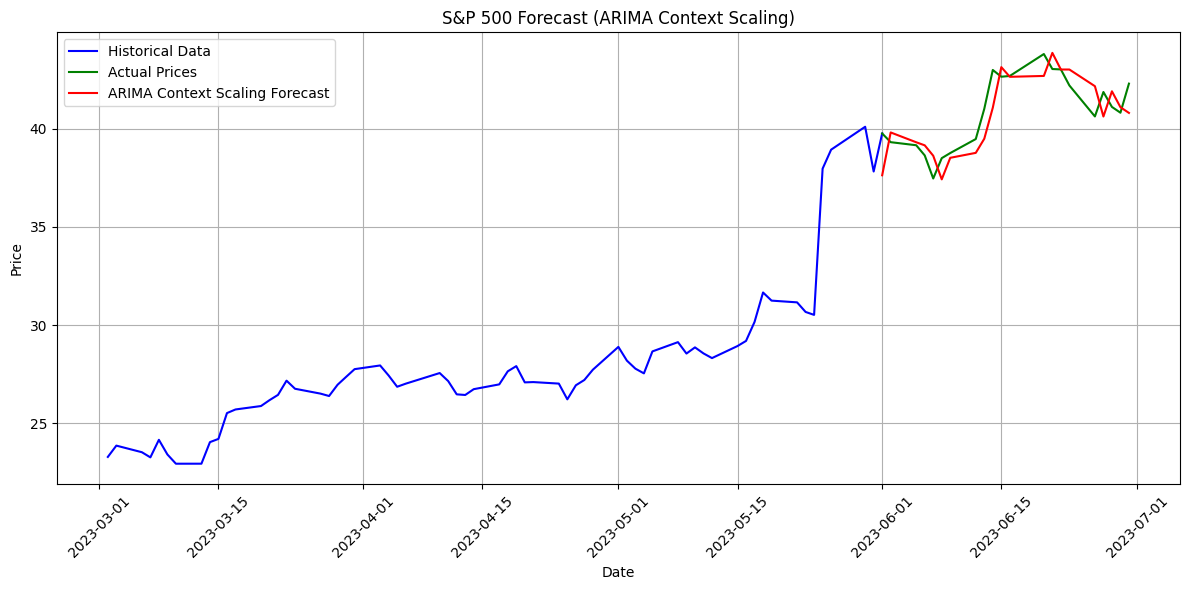

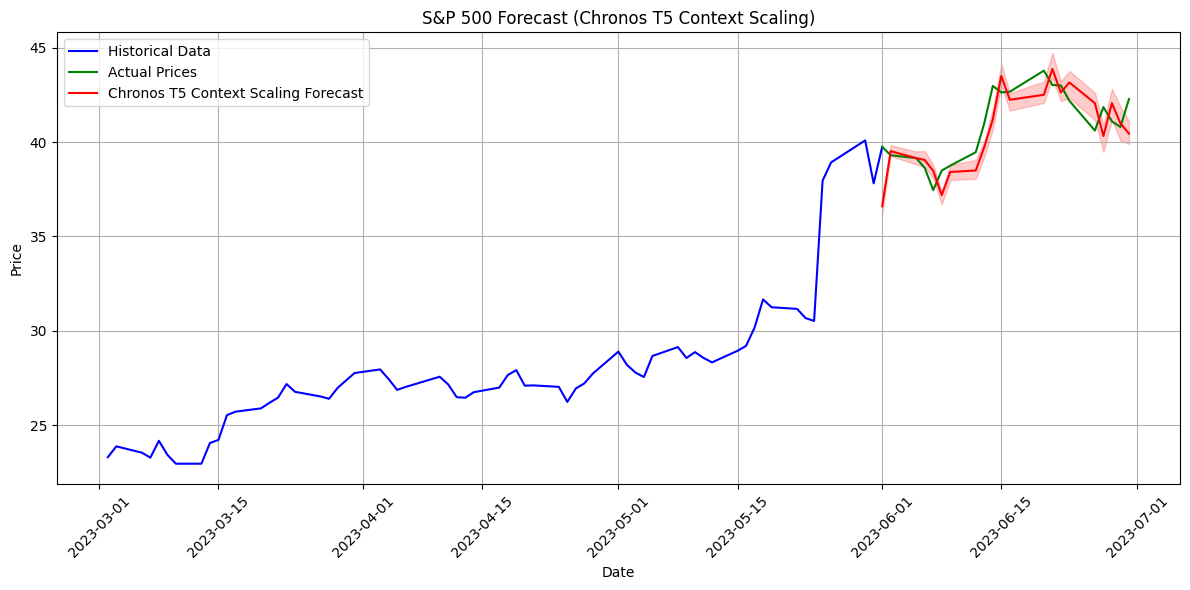

In [7]:
import yfinance as yf
import pandas as pd

nvidia_data = yf.download("NVDA", start="2000-01-01", end="2025-02-10")
nvidia_data.reset_index(inplace=True)
nvidia_data['Date'] = pd.to_datetime(nvidia_data['Date'])
nvidia_data

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler

from utils.metrics import calculate_metrics
from data.snp500 import snp500_daily

# Updated Constants
CONTEXT_WINDOW = 63
FORECAST_STEPS = 21
CONFIDENCE_ALPHA = 0.2
MIN_CONTEXT_SIZE = 10  # Minimum context size required for all models

# ======================
# ARIMA Implementation with Context Window Scaling
# ======================
class ARIMAPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast with context window scaling"""
        # Fit scaler on context window
        self.scaler.fit(context_data.reshape(-1, 1))
        scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        
        model = ARIMA(scaled_data, order=(1,1,1))
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=1)
        
        median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
        ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
        return ci[0][0], median, ci[0][1]

    
    def sliding_window_forecast(self, full_data, start_idx):
        """Forecast with sliding window using context window scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < MIN_CONTEXT_SIZE:
                raise ValueError(f"Insufficient context data (need ≥{MIN_CONTEXT_SIZE} samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation with Context Window Scaling
# ======================
class ChronosPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pipeline = ChronosPipeline.from_pretrained(
            # Update the path to your fine-tuned model
            "amazon/chronos-t5-large",
            device_map="mps",  # Change to "cuda" or "cpu" based on your hardware
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):

        # Fit scaler on context window
        self.scaler.fit(context_data.reshape(-1, 1))
        scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context = torch.tensor(scaled_data, dtype=torch.bfloat16)
        
        forecast = self.pipeline.predict(context, 1)
        forecast_np = forecast[0].cpu().numpy()
        
        forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
        return (
            np.quantile(forecast_original, 0.1).item(),
            np.quantile(forecast_original, 0.5).item(),
            np.quantile(forecast_original, 0.9).item()
        )

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < MIN_CONTEXT_SIZE:
                raise ValueError(f"Insufficient context data (need ≥{MIN_CONTEXT_SIZE} samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Multiple Trials Comparison
# ======================
def run_multiple_trials_comparison(full_data, n_trials=10, test_start=None):
    """Run trials for both models with consistent context window scaling approach."""
    
    # Ensure we have enough historical data for context
    if test_start < CONTEXT_WINDOW + MIN_CONTEXT_SIZE:
        raise ValueError(f"Test start index {test_start} too small, need at least {CONTEXT_WINDOW + MIN_CONTEXT_SIZE} for context")
    
    # Actual data over the forecast horizon
    actual = full_data['Close'].iloc[test_start : test_start + FORECAST_STEPS].values

    # Get the last historical point for directional accuracy calculation
    historical_last_point = float(full_data['Close'].iloc[test_start - 1]) if test_start > 0 else None

    print("\n----- DATA FOR MANUAL VALIDATION -----")
    print(f"Historical last point: {historical_last_point}")
    print(f"Actual values: {actual}")

    # In-sample data (used for metric calculation)
    insample_data = full_data['Close'].iloc[test_start - CONTEXT_WINDOW : test_start].values
    
    # ARIMA Context Window Scaling
    arima_context = ARIMAPredictorContextScale()
    arima_context_preds = arima_context.sliding_window_forecast(full_data, test_start)
    
    print(f"ARIMA predictions: {arima_context_preds['median']}")
    
    # Print dates to ensure alignment
    forecast_dates = [d.strftime('%Y-%m-%d') for d in arima_context_preds['dates']]
    print(f"Forecast dates: {forecast_dates}")
    
    # Simple table showing directions
    print("\n----- DIRECTIONAL ANALYSIS -----")
    print("Date | Actual | Direction | Predicted | Direction | Match?")
    
    # Ensure both arrays are flattened to 1D before concatenation
    ext_actual = np.concatenate([[historical_last_point], actual.flatten()])
    ext_predicted = np.concatenate([[historical_last_point], np.array(arima_context_preds['median']).flatten()])
    
    # Print each day's comparison
    for i in range(1, len(ext_actual)):
        actual_dir = "UP" if ext_actual[i] > ext_actual[i-1] else "DOWN" if ext_actual[i] < ext_actual[i-1] else "FLAT"
        pred_dir = "UP" if ext_predicted[i] > ext_predicted[i-1] else "DOWN" if ext_predicted[i] < ext_predicted[i-1] else "FLAT"
        
        # Only count non-FLAT actual movements for directional accuracy
        if actual_dir != "FLAT":
            match = "YES" if actual_dir == pred_dir else "NO"
        else:
            match = "N/A"
            
        # Print in date order (first date is missing since it's compared to historical)
        if i-1 < len(forecast_dates):
            date_str = forecast_dates[i-1]
        else:
            date_str = f"Day {i}"
            
        print(f"{date_str} | {ext_actual[i]:.2f} | {actual_dir} | {ext_predicted[i]:.2f} | {pred_dir} | {match}")
    
    # Calculate directional accuracy manually
    valid_directions = 0
    correct_directions = 0
    
    for i in range(1, len(ext_actual)):
        actual_dir = "UP" if ext_actual[i] > ext_actual[i-1] else "DOWN" if ext_actual[i] < ext_actual[i-1] else "FLAT"
        pred_dir = "UP" if ext_predicted[i] > ext_predicted[i-1] else "DOWN" if ext_predicted[i] < ext_predicted[i-1] else "FLAT"
        
        if actual_dir != "FLAT":
            valid_directions += 1
            if actual_dir == pred_dir:
                correct_directions += 1
    
    if valid_directions > 0:
        manual_accuracy = (correct_directions / valid_directions) * 100
        print(f"\nManual directional accuracy: {correct_directions}/{valid_directions} = {manual_accuracy:.2f}%")
    else:
        print("\nNo valid directions found for manual calculation")
    
    print("----- END VALIDATION -----\n")
    
    # Calculate metrics including directional accuracy with historical point
    arima_metrics = calculate_metrics(
        actual, 
        arima_context_preds['median'], 
        insample=insample_data,
        historical_last_point=historical_last_point  # Pass historical point
    )
    
    # Chronos Context Window Scaling
    chronos_context = ChronosPredictorContextScale()
    chronos_context_metrics_list = []
    chronos_context_preds = None
    
    for trial in range(n_trials):
        # Context window scaling trial
        chronos_context_preds = chronos_context.sliding_window_forecast(full_data, test_start)
        
        # Ensure the predictions are properly aligned with actual values
        if len(chronos_context_preds['median']) != len(actual):
            print(f"Warning: Chronos prediction length ({len(chronos_context_preds['median'])}) doesn't match actual data length ({len(actual)})")
            # Use the minimum length for evaluation
            min_length = min(len(chronos_context_preds['median']), len(actual))
            chronos_actual = actual[:min_length]
            chronos_preds = chronos_context_preds['median'][:min_length]
        else:
            chronos_actual = actual
            chronos_preds = chronos_context_preds['median']
        
        # Calculate metrics with historical point for better directional accuracy
        chronos_metrics = calculate_metrics(
            chronos_actual, 
            chronos_preds, 
            insample=insample_data,
            historical_last_point=historical_last_point  # Pass historical point
        )
        
        chronos_context_metrics_list.append(chronos_metrics)
        
        print(f"\nTrial {trial+1}/{n_trials}")
        print("Context scaling metrics:", chronos_metrics)
    
    # Average & std for Chronos Context
    chronos_context_avg = {
        metric: np.mean([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    chronos_context_std = {
        metric: np.std([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    
    return (
        arima_metrics, 
        chronos_context_avg,
        chronos_context_std,
        arima_context_preds,
        chronos_context_preds
    )

# ======================
# Plotting
# ======================
def plot_individual_forecast(data, start_idx, forecasts, model_name, actual_data=None):
    """Plotting function with proper index alignment and verification."""
    plt.figure(figsize=(12, 6))
    
    # Historical data (context window before forecast start)
    historical_start = max(0, start_idx - 63)
    historical = data.iloc[historical_start:start_idx+1]
    plt.plot(historical['Date'], historical['Close'], 'b-', label='Historical Data')
    
    # Actual values with verified indices
    actual_dates = data['Date'].iloc[start_idx:start_idx+FORECAST_STEPS]
    actual_values = data['Close'].iloc[start_idx:start_idx+FORECAST_STEPS]
    
    if actual_data is not None:
        # Use provided actual data if available
        if len(actual_data) != len(actual_dates):
            print(f"Warning: Provided actual data length ({len(actual_data)}) doesn't match expected ({len(actual_dates)})")
        
        plt.plot(actual_dates[:len(actual_data)], actual_data, 'g-', label='Actual Prices')
    else:
        plt.plot(actual_dates, actual_values, 'g-', label='Actual Prices')
    
    # Forecasts with alignment validation
    forecast_dates = forecasts['dates']
    if len(forecast_dates) != len(actual_dates):
        print(f"Warning: Forecast length ({len(forecast_dates)}) doesn't match actual data length ({len(actual_dates)})")
        # Use the minimum length for plotting
        plot_length = min(len(forecast_dates), len(actual_dates))
        forecast_dates = forecast_dates[:plot_length]
        actual_dates = actual_dates[:plot_length]

    # Updated IF check to cover both ARIMA naming conventions:
    if model_name in ["ARIMA Global Scaling", "ARIMA Context Scaling"]:
        # ARIMA -> No confidence fill
        plt.plot(forecast_dates, forecasts['median'][:len(forecast_dates)], 'r-', label=f'{model_name} Forecast')
    else:
        # Chronos -> Plot fill-between for confidence
        plt.plot(forecast_dates, forecasts['median'][:len(forecast_dates)], 'r-', label=f'{model_name} Forecast')
        plt.fill_between(
            forecast_dates, 
            forecasts['low'][:len(forecast_dates)], 
            forecasts['high'][:len(forecast_dates)], 
            color='red', 
            alpha=0.2
        )
    
    plt.title(f'S&P 500 Forecast ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ======================
# Main Entry
# ======================
def main():
    from data.snp500 import snp500_daily
    snp500_daily = nvidia_data
    
    # Select test start date
    test_date_str = "2023-06-01"
    # Find the index where date matches or closest date before
    test_date = pd.Timestamp(test_date_str)
    date_indices = snp500_daily[snp500_daily['Date'] <= test_date].index
    if len(date_indices) == 0:
        raise ValueError(f"No dates before {test_date_str} found in the dataset")
    test_start = date_indices[-1]
    
    # Run comparison
    results = run_multiple_trials_comparison(
        snp500_daily, 
        n_trials=10, 
        test_start=test_start
    )
    
    (arima_context_metrics, 
        chronos_context_avg, chronos_context_std,
        arima_context_preds,
        chronos_context_preds) = results
    
    print("\nARIMA Context Window Scaling Metrics:")
    for metric, value in arima_context_metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nChronos Context Window Scaling Metrics (Average ± Std):")
    for metric in chronos_context_avg:
        print(f"{metric}: {chronos_context_avg[metric]:.4f} ± {chronos_context_std[metric]:.4f}")
    
    # Plot results
    plot_individual_forecast(snp500_daily, test_start, arima_context_preds, "ARIMA Context Scaling")
    plot_individual_forecast(snp500_daily, test_start, chronos_context_preds, "Chronos T5 Context Scaling")
    

if __name__ == "__main__":
    main()

[4200.06835938 4146.39013672 4200.06835938 4200.06835938 4200.06835938
 4226.90771484 4200.06835938 4146.39013672 4146.39013672 4146.39013672
 4146.39013672 4146.39013672 4146.39013672 4146.39013672 4146.39013672
 4146.39013672 4146.39013672 4092.71166992 4119.55090332 4119.55090332
 4092.71166992]
DatetimeIndex(['2023-06-01', '2023-06-02', '2023-06-05', '2023-06-06',
               '2023-06-07', '2023-06-08', '2023-06-09', '2023-06-12',
               '2023-06-13', '2023-06-14', '2023-06-15', '2023-06-16',
               '2023-06-19', '2023-06-20', '2023-06-21', '2023-06-22',
               '2023-06-23', '2023-06-26', '2023-06-27', '2023-06-28',
               '2023-06-29'],
              dtype='datetime64[ns]', freq='B')


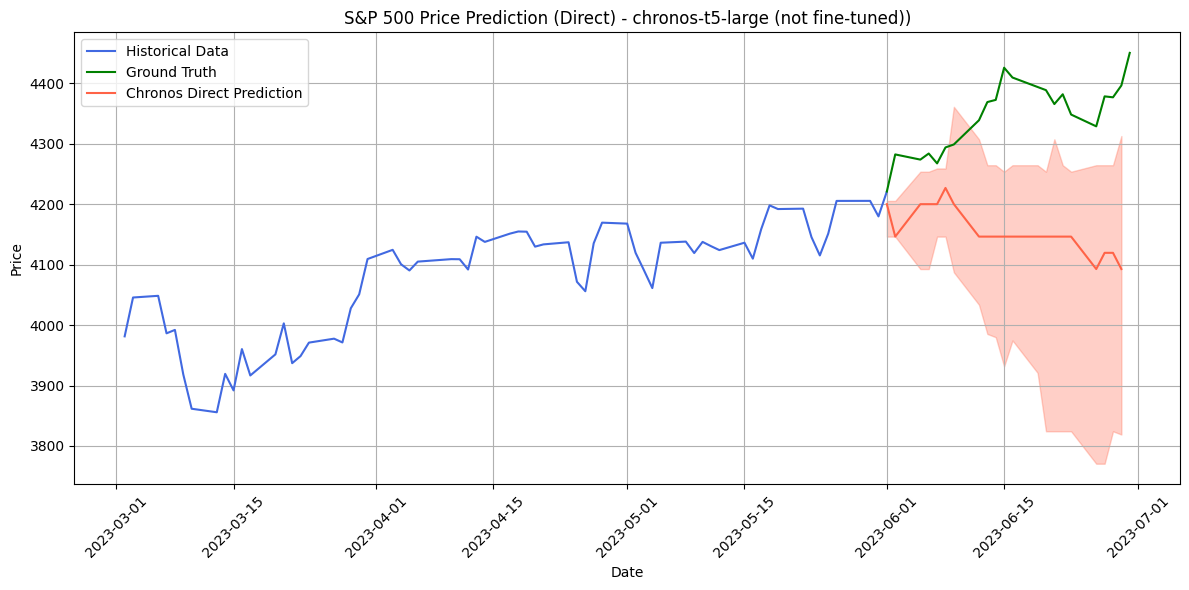


Chronos Direct Forecast Metrics:
MAE: 190.0364
MSE: 44005.0708
RMSE: 209.7739
Z-NormalizedMAE: 3.2734
Z-NormalizedMSE: 13.0566
Z-NormalizedRMSE: 3.6134
MAPE: 4.3475
SMAPE: 4.4653
MASE: nan
DirectionalAccuracy: nan


In [220]:
import pandas as pd
import numpy as np
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from utils.metrics import calculate_metrics
from data.snp500 import snp500_daily

# 1750，64
# 1600, 21

CONTEXT_WINDOW = 1600
FORECAST_STEPS = 21
PREDICTION_LENGTH = 1

sp500_d = snp500_daily

pipeline = ChronosPipeline.from_pretrained(
    # "./ft_chronos_sp500_closing_rk2/checkpoint-final",
    # "./ft_chronos_tiny_rk2_3000/checkpoint-final",
    "amazon/chronos-t5-large",
    device_map="mps",
    torch_dtype=torch.bfloat16,
)

class TimeSeriesPredictor:
    def __init__(self):
        self.scaler = StandardScaler()

    def fit_scaler(self, data):
        self.scaler.fit(data.reshape(-1, 1))
        
    def generate_single_forecast(self, context_data):
        context_scaled = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context = torch.tensor(context_scaled, dtype=torch.float32)
        with torch.no_grad():
            forecast = pipeline.predict(context, PREDICTION_LENGTH)
        forecast_np = forecast[0].cpu().numpy()
        forecast_unscaled = self.scaler.inverse_transform(forecast_np.reshape(-1, 1)).reshape(forecast_np.shape)
        low = np.quantile(forecast_unscaled, 0.1, axis=0).item()
        median = np.quantile(forecast_unscaled, 0.5, axis=0).item()
        high = np.quantile(forecast_unscaled, 0.9, axis=0).item()
        return low, median, high

    def generate_direct_multi_step_forecast(self, context_data, horizon=FORECAST_STEPS):
        context_scaled = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context_tensor = torch.tensor(context_scaled, dtype=torch.float32)
        with torch.no_grad():
            forecast = pipeline.predict(context_tensor, horizon)
        forecast_np = forecast[0].cpu().numpy()
        forecast_unscaled = self.scaler.inverse_transform(forecast_np.reshape(-1, 1)).reshape(forecast_np.shape)
        low_arr = np.quantile(forecast_unscaled, 0.1, axis=0)
        median_arr = np.quantile(forecast_unscaled, 0.5, axis=0)
        high_arr = np.quantile(forecast_unscaled, 0.9, axis=0)
        return low_arr, median_arr, high_arr

    def generate_direct_multi_step_forecasts(self, data, start_idx):
        all_forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        context_data = data['Close'].iloc[start_idx - CONTEXT_WINDOW : start_idx].to_numpy()
        self.fit_scaler(context_data)
        low_arr, median_arr, high_arr = self.generate_direct_multi_step_forecast(context_data, horizon=FORECAST_STEPS)
        print(median_arr)
        forecast_dates = pd.date_range(start=data['Date'].iloc[start_idx], periods=FORECAST_STEPS, freq='B')
        print(forecast_dates)
        all_forecasts['low'] = low_arr
        all_forecasts['median'] = median_arr
        all_forecasts['high'] = high_arr
        all_forecasts['dates'] = forecast_dates
        return all_forecasts

def plot_forecasts(data, start_idx, forecasts, method):
    plt.figure(figsize=(12, 6))
    context_data = data.iloc[start_idx - 63:start_idx + 1]
    plt.plot(context_data['Date'], context_data['Close'], color='royalblue', label='Historical Data')
    actual_data = data.iloc[start_idx:start_idx + FORECAST_STEPS]
    plt.plot(actual_data['Date'], actual_data['Close'], color='green', label='Ground Truth')
    plt.plot(forecasts['dates'], forecasts['median'], color='tomato', label=f'Chronos {method.capitalize()} Prediction')
    plt.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'], color='tomato', alpha=0.3)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'S&P 500 Price Prediction ({method.capitalize()}) - chronos-t5-large (not fine-tuned))')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_experiment(data, target_date, method="direct"):
    predictor = TimeSeriesPredictor()
    target_date = pd.Timestamp(target_date)
    start_idx = data[data['Date'] <= target_date].index[-1]
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")
    if method.lower() == "direct":
        forecasts = predictor.generate_direct_multi_step_forecasts(data, start_idx)
    plot_forecasts(data, start_idx, forecasts, method)
    actual_values = data['Close'].iloc[start_idx:start_idx + FORECAST_STEPS].values
    metrics = calculate_metrics(actual_values, np.array(forecasts['median']))
    print(f"\nChronos {method.capitalize()} Forecast Metrics:")
    for metric_name, value in metrics.items():
        if value is not None:
            print(f"{metric_name}: {value:.4f}")
        else:
            print(f"{metric_name}: None")

run_experiment(sp500_d, "2023-05-31", method="direct")


[4175.51196289 4181.80834961 4197.55004883 4200.69824219 4191.25341797
 4194.40161133 4203.84667969 4206.99487305 4210.14306641 4206.99487305
 4206.99462891 4219.58789062 4206.99487305 4222.73632812 4219.58789062
 4232.18115234 4222.73632812 4206.99487305 4210.14306641 4241.62597656
 4225.88452148]
DatetimeIndex(['2023-06-01', '2023-06-02', '2023-06-05', '2023-06-06',
               '2023-06-07', '2023-06-08', '2023-06-09', '2023-06-12',
               '2023-06-13', '2023-06-14', '2023-06-15', '2023-06-16',
               '2023-06-19', '2023-06-20', '2023-06-21', '2023-06-22',
               '2023-06-23', '2023-06-26', '2023-06-27', '2023-06-28',
               '2023-06-29'],
              dtype='datetime64[ns]', freq='B')


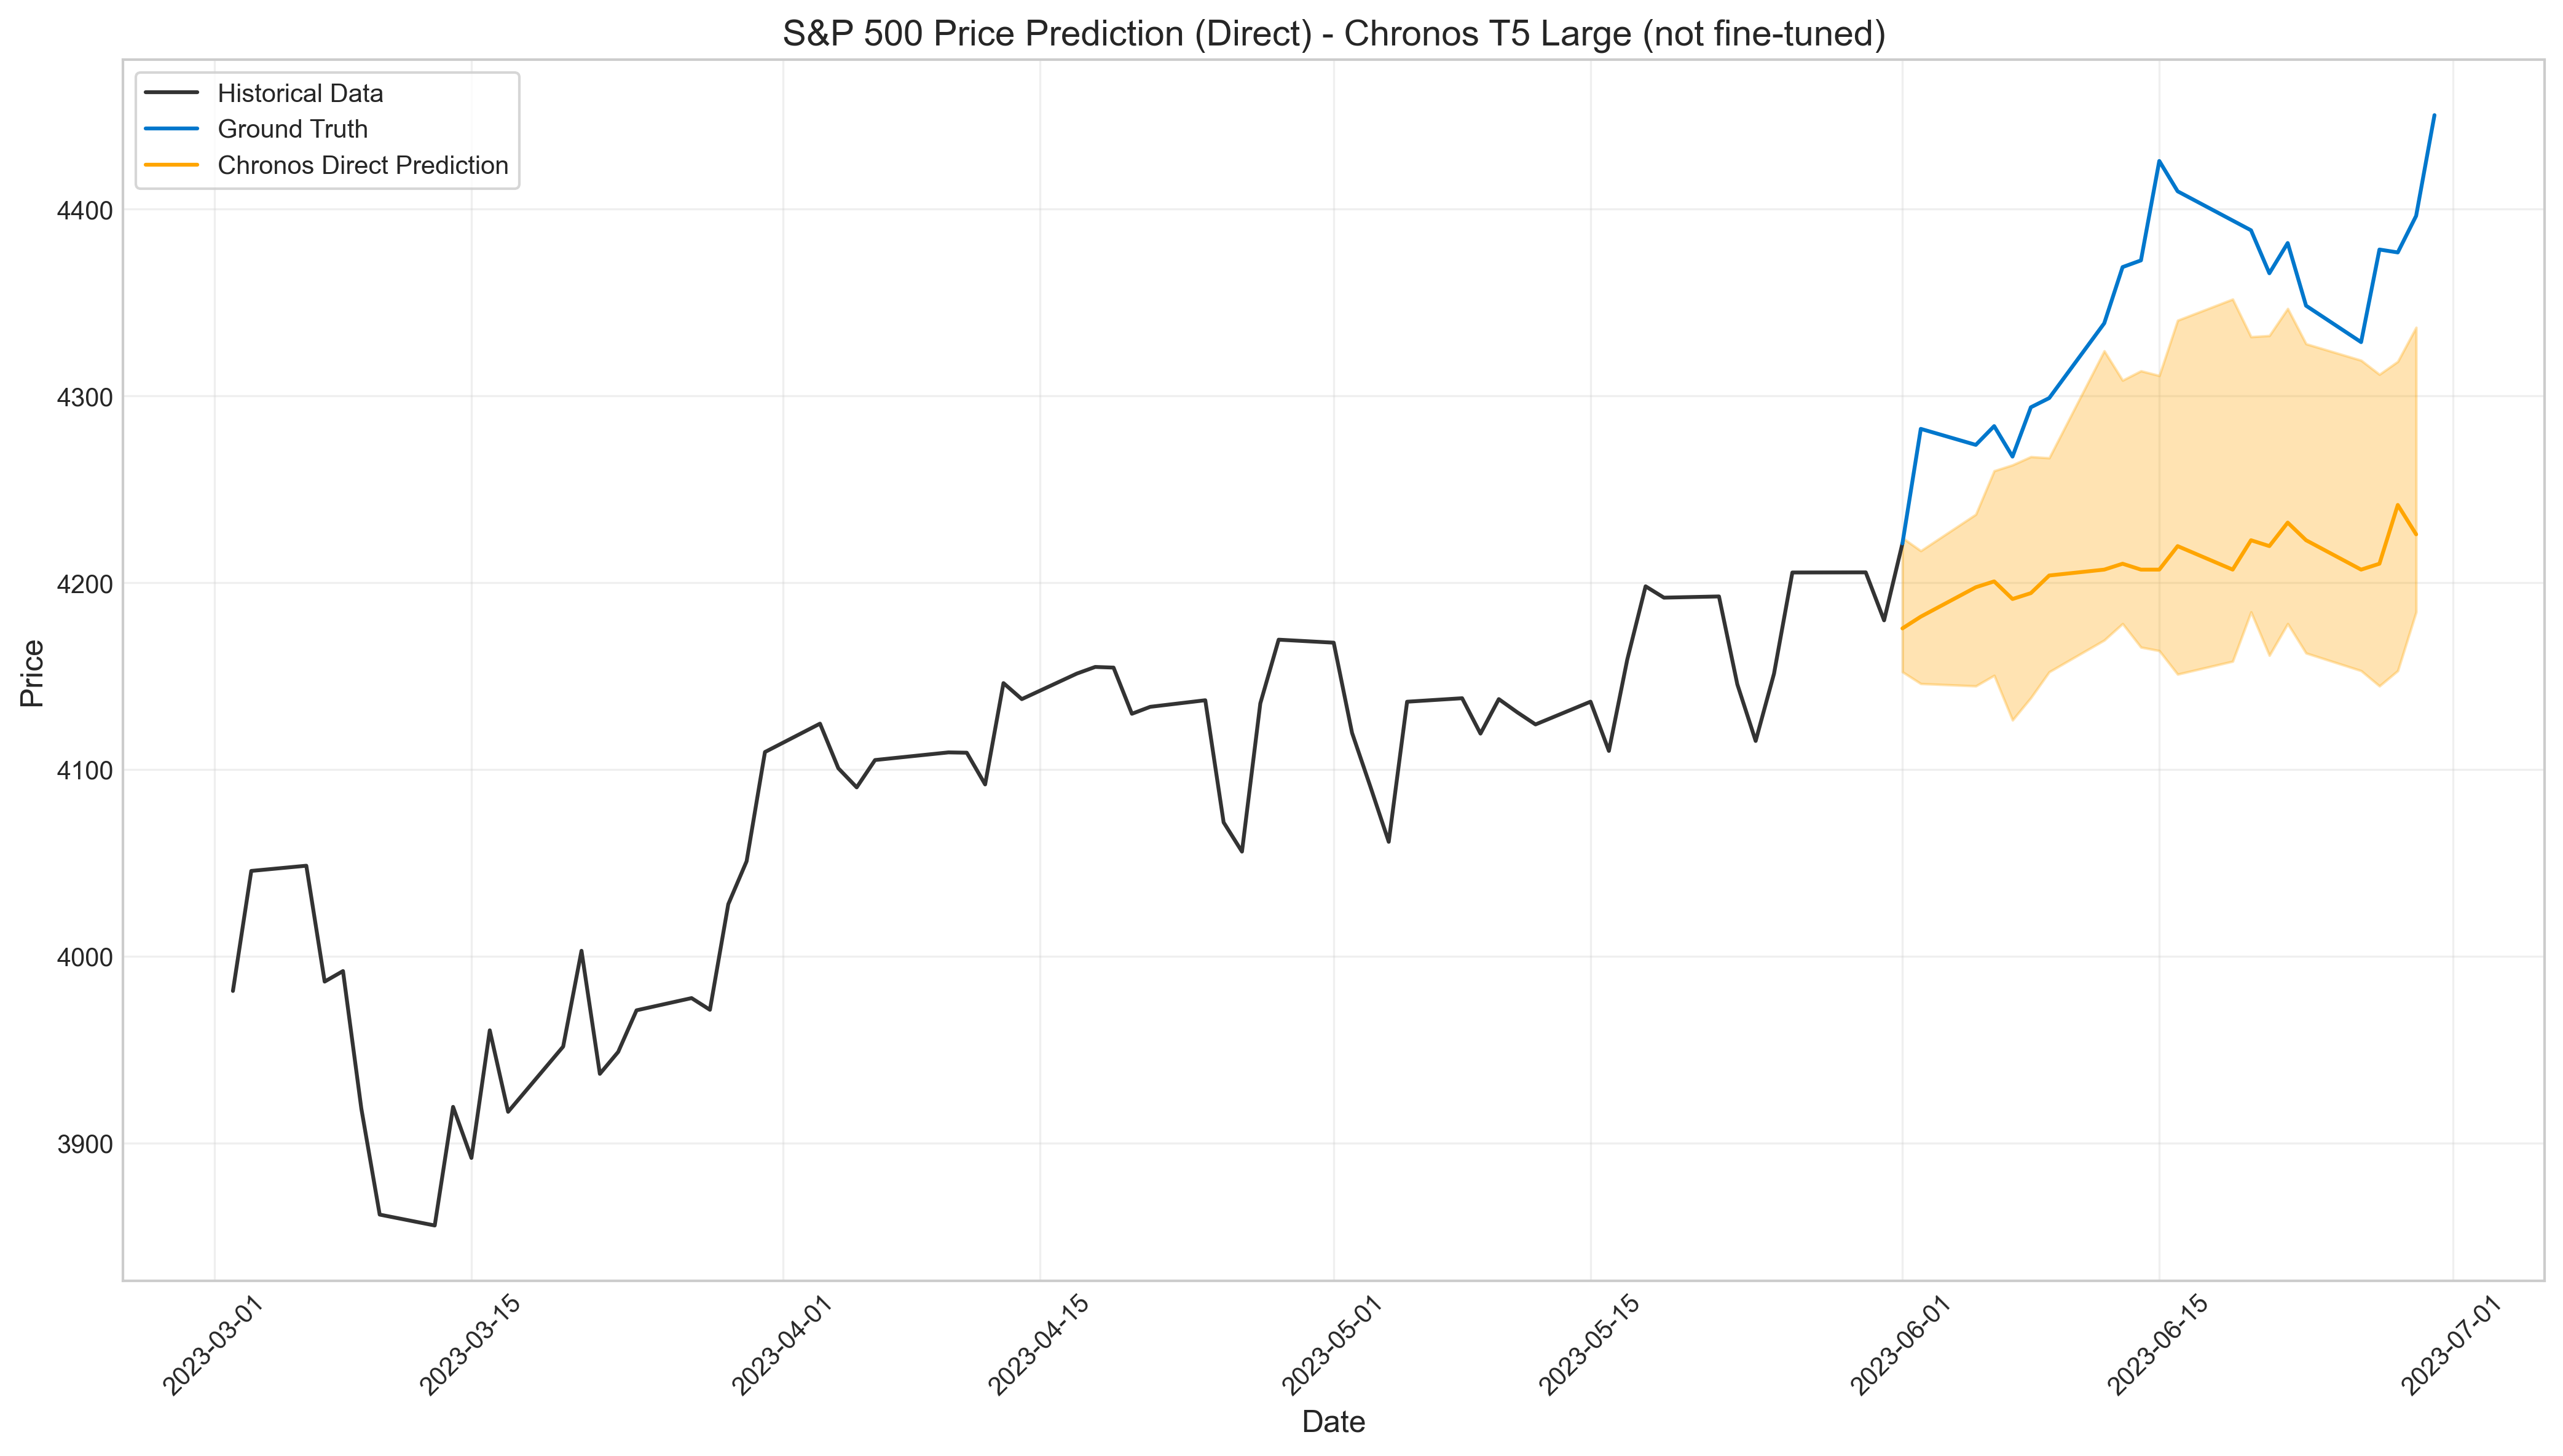


Chronos Direct Forecast Metrics:
MAE: 136.5790
MSE: 20943.2048
RMSE: 144.7177
Z-NormalizedMAE: 2.3526
Z-NormalizedMSE: 6.2140
Z-NormalizedRMSE: 2.4928
MAPE: 3.1293
SMAPE: 3.1849
MASE: nan
DirectionalAccuracy: nan


In [17]:
import pandas as pd
import numpy as np
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from utils.metrics import calculate_metrics
from data.snp500 import snp500_daily

# 1750，64
# 1600, 21

CONTEXT_WINDOW = 1600
FORECAST_STEPS = 21
PREDICTION_LENGTH = 1

sp500_d = snp500_daily

pipeline = ChronosPipeline.from_pretrained(
    # "./ft_chronos_sp500_closing_rk2/checkpoint-final",
    # "./ft_chronos_tiny_rk2_3000/checkpoint-final",
    "amazon/chronos-t5-large",
    device_map="mps",
    torch_dtype=torch.bfloat16,
)

class TimeSeriesPredictor:
    def __init__(self):
        self.scaler = StandardScaler()

    def fit_scaler(self, data):
        self.scaler.fit(data.reshape(-1, 1))
        
    def generate_single_forecast(self, context_data):
        context_scaled = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context = torch.tensor(context_scaled, dtype=torch.float32)
        with torch.no_grad():
            forecast = pipeline.predict(context, PREDICTION_LENGTH)
        forecast_np = forecast[0].cpu().numpy()
        forecast_unscaled = self.scaler.inverse_transform(forecast_np.reshape(-1, 1)).reshape(forecast_np.shape)
        low = np.quantile(forecast_unscaled, 0.1, axis=0).item()
        median = np.quantile(forecast_unscaled, 0.5, axis=0).item()
        high = np.quantile(forecast_unscaled, 0.9, axis=0).item()
        return low, median, high

    def generate_direct_multi_step_forecast(self, context_data, horizon=FORECAST_STEPS):
        context_scaled = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context_tensor = torch.tensor(context_scaled, dtype=torch.float32)
        with torch.no_grad():
            forecast = pipeline.predict(context_tensor, horizon)
        forecast_np = forecast[0].cpu().numpy()
        forecast_unscaled = self.scaler.inverse_transform(forecast_np.reshape(-1, 1)).reshape(forecast_np.shape)
        low_arr = np.quantile(forecast_unscaled, 0.1, axis=0)
        median_arr = np.quantile(forecast_unscaled, 0.5, axis=0)
        high_arr = np.quantile(forecast_unscaled, 0.9, axis=0)
        return low_arr, median_arr, high_arr

    def generate_direct_multi_step_forecasts(self, data, start_idx):
        all_forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        context_data = data['Close'].iloc[start_idx - CONTEXT_WINDOW : start_idx].to_numpy()
        self.fit_scaler(context_data)
        low_arr, median_arr, high_arr = self.generate_direct_multi_step_forecast(context_data, horizon=FORECAST_STEPS)
        print(median_arr)
        forecast_dates = pd.date_range(start=data['Date'].iloc[start_idx], periods=FORECAST_STEPS, freq='B')
        print(forecast_dates)
        all_forecasts['low'] = low_arr
        all_forecasts['median'] = median_arr
        all_forecasts['high'] = high_arr
        all_forecasts['dates'] = forecast_dates
        return all_forecasts

def plot_forecasts(data, start_idx, forecasts, method):
    # Define custom high-quality settings and palette
    import matplotlib.pyplot as plt
    custom_palette = ["#4eb3a5", "#e34a33", "#9e9ac8", "#377eb8"]
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 400
    plt.rcParams['figure.figsize'] = (14, 8)

    # Create the figure
    fig, ax = plt.subplots()

    # Plot historical data with custom color
    context_data = data.iloc[start_idx - 63 : start_idx + 1]
    ax.plot(context_data['Date'], context_data['Close'], 
            label='Historical Data', 
            color="#333333",
            linewidth=1.5)

    # Plot ground truth for the forecast period
    actual_data = data.iloc[start_idx : start_idx + FORECAST_STEPS]
    ax.plot(actual_data['Date'], actual_data['Close'], 
            label='Ground Truth', 
            color="#0077CC",
            linewidth=1.5)

    # Plot forecast median and uncertainty band
    ax.plot(forecasts['dates'], forecasts['median'], 
            label=f'Chronos {method.capitalize()} Prediction', 
            color="#FFA500",
            linewidth=1.5)
    ax.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'], 
                    color="#FFA500", alpha=0.3)

    # Set labels and title with improved formatting
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.set_title(f"S&P 500 Price Prediction ({method.capitalize()}) - Chronos T5 Large (not fine-tuned)", fontsize=14)
    
    # Improve x-tick formatting
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)

    # Add legend with a clear layout
    ax.legend(fontsize=10, frameon=True)
    
    # Add grid lines with slight transparency for readability
    ax.grid(True, alpha=0.3)

    # Adjust layout for publication-quality output
    plt.tight_layout()
    plt.show()

def run_experiment(data, target_date, method="direct"):
    predictor = TimeSeriesPredictor()
    target_date = pd.Timestamp(target_date)
    start_idx = data[data['Date'] <= target_date].index[-1]
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")
    if method.lower() == "direct":
        forecasts = predictor.generate_direct_multi_step_forecasts(data, start_idx)
    plot_forecasts(data, start_idx, forecasts, method)
    actual_values = data['Close'].iloc[start_idx:start_idx + FORECAST_STEPS].values
    metrics = calculate_metrics(actual_values, np.array(forecasts['median']))
    print(f"\nChronos {method.capitalize()} Forecast Metrics:")
    for metric_name, value in metrics.items():
        if value is not None:
            print(f"{metric_name}: {value:.4f}")
        else:
            print(f"{metric_name}: None")

run_experiment(sp500_d, "2023-05-31", method="direct")


In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler
from utils.metrics import calculate_metrics
from data.snp500 import snp500_daily

# Download sample data (using Nvidia data as in your example)
nvidia_data = yf.download("NVDA", start="2000-01-01", end="2025-02-10")
nvidia_data.reset_index(inplace=True)
nvidia_data['Date'] = pd.to_datetime(nvidia_data['Date'])

# Updated Constants
CONTEXT_WINDOW = 63
FORECAST_STEPS = 21
CONFIDENCE_ALPHA = 0.2
MIN_CONTEXT_SIZE = 10  # Minimum context size required for all models

# ======================
# High-Quality Plotting Function
# ======================
def plot_forecasts(data, start_idx, forecasts, method):
    # Custom high-quality settings and palette
    custom_palette = {
        "historical": "#333333",  # dark grey for historical data
        "ground_truth": "#0077CC", # bright blue for ground truth
        "forecast": "#FFA500",
        "prediction_interval": "#FF7F0E"    # bright orange for forecast median & fill
    }
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 400
    plt.rcParams['figure.figsize'] = (14, 8)

    # Create the figure and axis
    fig, ax = plt.subplots()

    # Plot historical data (context window before forecast start)
    context_data = data.iloc[start_idx - CONTEXT_WINDOW : start_idx + 1]
    ax.plot(context_data['Date'], context_data['Close'], 
            label='Historical Data', 
            color=custom_palette["historical"],
            linewidth=1.75)

    # Plot ground truth for the forecast period
    actual_data = data.iloc[start_idx : start_idx + FORECAST_STEPS]
    ax.plot(actual_data['Date'], actual_data['Close'], 
            label='Ground Truth', 
            color=custom_palette["ground_truth"],
            linewidth=1.75)

    # Plot forecast median and uncertainty band
    ax.plot(forecasts['dates'], forecasts['median'], 
            label=f'{method.capitalize()} Prediction', 
            color=custom_palette["forecast"],
            linewidth=1.75)
    ax.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'], 
                    color=custom_palette["forecast"], alpha=0.4)

    # Set labels and title with improved formatting
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.set_title(f"S&P 500 Price Prediction ({method.capitalize()}) - {method} Model", fontsize=14)
    
    # Improve x-tick formatting
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)

    # Add legend with a clear layout
    ax.legend(fontsize=10, frameon=True)
    
    # Add grid lines with slight transparency for readability
    ax.grid(True, alpha=0.3)

    # Adjust layout for publication-quality output
    plt.tight_layout()
    plt.show()

# ======================
# ARIMA Implementation with Context Window Scaling
# ======================
class ARIMAPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast with context window scaling"""
        # Fit scaler on context window
        self.scaler.fit(context_data.reshape(-1, 1))
        scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        
        model = ARIMA(scaled_data, order=(1,1,1))
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=1)
        
        median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
        ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
        return ci[0][0], median, ci[0][1]

    def sliding_window_forecast(self, full_data, start_idx):
        """Forecast with sliding window using context window scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < MIN_CONTEXT_SIZE:
                raise ValueError(f"Insufficient context data (need ≥{MIN_CONTEXT_SIZE} samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation with Context Window Scaling
# ======================
class ChronosPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-large",
            device_map="mps",  # Change to "cuda" or "cpu" based on your hardware
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        # Fit scaler on context window
        self.scaler.fit(context_data.reshape(-1, 1))
        scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context = torch.tensor(scaled_data, dtype=torch.bfloat16)
        
        forecast = self.pipeline.predict(context, 1)
        forecast_np = forecast[0].cpu().numpy()
        
        forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
        return (
            np.quantile(forecast_original, 0.1).item(),
            np.quantile(forecast_original, 0.5).item(),
            np.quantile(forecast_original, 0.9).item()
        )

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < MIN_CONTEXT_SIZE:
                raise ValueError(f"Insufficient context data (need ≥{MIN_CONTEXT_SIZE} samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Multiple Trials Comparison
# ======================
def run_multiple_trials_comparison(full_data, n_trials=10, test_start=None):
    """Run trials for both models with consistent context window scaling approach."""
    
    # Ensure we have enough historical data for context
    if test_start < CONTEXT_WINDOW + MIN_CONTEXT_SIZE:
        raise ValueError(f"Test start index {test_start} too small, need at least {CONTEXT_WINDOW + MIN_CONTEXT_SIZE} for context")
    
    # Actual data over the forecast horizon
    actual = full_data['Close'].iloc[test_start : test_start + FORECAST_STEPS].values

    # Get the last historical point for directional accuracy calculation
    historical_last_point = float(full_data['Close'].iloc[test_start - 1]) if test_start > 0 else None

    print("\n----- DATA FOR MANUAL VALIDATION -----")
    print(f"Historical last point: {historical_last_point}")
    print(f"Actual values: {actual}")

    # In-sample data (used for metric calculation)
    insample_data = full_data['Close'].iloc[test_start - CONTEXT_WINDOW : test_start].values
    
    # ARIMA Context Window Scaling
    arima_context = ARIMAPredictorContextScale()
    arima_context_preds = arima_context.sliding_window_forecast(full_data, test_start)
    
    print(f"ARIMA predictions: {arima_context_preds['median']}")
    
    # Print dates to ensure alignment
    forecast_dates = [d.strftime('%Y-%m-%d') for d in arima_context_preds['dates']]
    print(f"Forecast dates: {forecast_dates}")
    
    # Simple table showing directions
    print("\n----- DIRECTIONAL ANALYSIS -----")
    print("Date | Actual | Direction | Predicted | Direction | Match?")
    
    # Ensure both arrays are flattened to 1D before concatenation
    ext_actual = np.concatenate([[historical_last_point], actual.flatten()])
    ext_predicted = np.concatenate([[historical_last_point], np.array(arima_context_preds['median']).flatten()])
    
    # Print each day's comparison
    for i in range(1, len(ext_actual)):
        actual_dir = "UP" if ext_actual[i] > ext_actual[i-1] else "DOWN" if ext_actual[i] < ext_actual[i-1] else "FLAT"
        pred_dir = "UP" if ext_predicted[i] > ext_predicted[i-1] else "DOWN" if ext_predicted[i] < ext_predicted[i-1] else "FLAT"
        
        # Only count non-FLAT actual movements for directional accuracy
        if actual_dir != "FLAT":
            match = "YES" if actual_dir == pred_dir else "NO"
        else:
            match = "N/A"
            
        # Print in date order (first date is missing since it's compared to historical)
        if i-1 < len(forecast_dates):
            date_str = forecast_dates[i-1]
        else:
            date_str = f"Day {i}"
            
        print(f"{date_str} | {ext_actual[i]:.2f} | {actual_dir} | {ext_predicted[i]:.2f} | {pred_dir} | {match}")
    
    # Calculate directional accuracy manually
    valid_directions = 0
    correct_directions = 0
    
    for i in range(1, len(ext_actual)):
        actual_dir = "UP" if ext_actual[i] > ext_actual[i-1] else "DOWN" if ext_actual[i] < ext_actual[i-1] else "FLAT"
        pred_dir = "UP" if ext_predicted[i] > ext_predicted[i-1] else "DOWN" if ext_predicted[i] < ext_predicted[i-1] else "FLAT"
        
        if actual_dir != "FLAT":
            valid_directions += 1
            if actual_dir == pred_dir:
                correct_directions += 1
    
    if valid_directions > 0:
        manual_accuracy = (correct_directions / valid_directions) * 100
        print(f"\nManual directional accuracy: {correct_directions}/{valid_directions} = {manual_accuracy:.2f}%")
    else:
        print("\nNo valid directions found for manual calculation")
    
    print("----- END VALIDATION -----\n")
    
    # Calculate metrics for ARIMA predictions
    arima_metrics = calculate_metrics(
        actual, 
        arima_context_preds['median'], 
        insample=insample_data,
        historical_last_point=historical_last_point
    )
    
    # Chronos Context Window Scaling
    chronos_context = ChronosPredictorContextScale()
    chronos_context_metrics_list = []
    chronos_context_preds = None
    
    for trial in range(n_trials):
        chronos_context_preds = chronos_context.sliding_window_forecast(full_data, test_start)
        
        # Ensure predictions align with actual values
        if len(chronos_context_preds['median']) != len(actual):
            print(f"Warning: Chronos prediction length ({len(chronos_context_preds['median'])}) doesn't match actual data length ({len(actual)})")
            min_length = min(len(chronos_context_preds['median']), len(actual))
            chronos_actual = actual[:min_length]
            chronos_preds = chronos_context_preds['median'][:min_length]
        else:
            chronos_actual = actual
            chronos_preds = chronos_context_preds['median']
        
        chronos_metrics = calculate_metrics(
            chronos_actual, 
            chronos_preds, 
            insample=insample_data,
            historical_last_point=historical_last_point
        )
        
        chronos_context_metrics_list.append(chronos_metrics)
        
        print(f"\nTrial {trial+1}/{n_trials}")
        print("Context scaling metrics:", chronos_metrics)
    
    # Average & std for Chronos Context
    chronos_context_avg = {
        metric: np.mean([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    chronos_context_std = {
        metric: np.std([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    
    return (
        arima_metrics, 
        chronos_context_avg,
        chronos_context_std,
        arima_context_preds,
        chronos_context_preds
    )

# ======================
# Main Entry
# ======================
def main():
    # Use the downloaded Nvidia data as an example
    snp500_daily = nvidia_data
    
    # Select test start date
    test_date_str = "2023-06-01"
    test_date = pd.Timestamp(test_date_str)
    date_indices = snp500_daily[snp500_daily['Date'] <= test_date].index
    if len(date_indices) == 0:
        raise ValueError(f"No dates before {test_date_str} found in the dataset")
    test_start = date_indices[-1]
    
    # Run comparison
    results = run_multiple_trials_comparison(
        snp500_daily, 
        n_trials=1, 
        test_start=test_start
    )
    
    (arima_context_metrics, 
     chronos_context_avg, chronos_context_std,
     arima_context_preds,
     chronos_context_preds) = results
    
    print("\nARIMA Context Window Scaling Metrics:")
    for metric, value in arima_context_metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nChronos Context Window Scaling Metrics (Average ± Std):")
    for metric in chronos_context_avg:
        print(f"{metric}: {chronos_context_avg[metric]:.4f} ± {chronos_context_std[metric]:.4f}")
    
    # Plot results using the new high-quality plot_forecasts function
    plot_forecasts(snp500_daily, test_start, arima_context_preds, "ARIMA Context Scaling")
    plot_forecasts(snp500_daily, test_start, chronos_context_preds, "Chronos T5 Context Scaling")
    
if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'utils.metrics'